In [4]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)

In [5]:
def prepare(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if 'latitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'latitude']
    if 'longitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'longitude']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = MinMaxScaler()
    numerical_scaled = scaler.fit_transform(numerical_df.values)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, initial_centroids=None, max_iter=300):
    models = []
    for i in range(k_min):
        models.append(None)

    for k in tqdm(range(k_min, k_max+1)):
        if initial_centroids is None:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
        else:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
        model.fit(df)
        models.append(model)

    return models


def scores(models, df, k_min, k_max, sample_size=-1, n_samples=1):
    SSEs = []
    separations = []
    silhouettess = []

    for i in range(0, k_min):
        SSEs.append(None)
        separations.append(None)
        silhouettess.append([])
    
    models = models[k_min:k_max+1]

    k = k_min

    for model in models:
        
        SSEs.append(model.inertia_)
        separations.append(metrics.davies_bouldin_score(df, model.labels_))

        silhouettes = []

        if n_samples > 0:
            print(f'k = {k}')
            for j in tqdm(range(0, n_samples)):
                if sample_size == -1:
                    sample_size = df.shape[0]   
                sampled_indeces = random.sample(range(df.shape[0]), sample_size)
                sampled_points = [df.iloc[i] for i in sampled_indeces]
                sampled_labels = [model.labels_[i] for i in sampled_indeces]
                silhouettes.append(silhouette_score(sampled_points, sampled_labels))

        silhouettess.append(silhouettes)
        k += 1
    
    scoress_dict = {
        'SSE': SSEs,
        'Separation': separations,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    combined = list(zip(columns, max_scores))
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    sorted_cols = [item for item, score in sorted_combined]
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scores_dict, k_min, k_max):
    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=len(scores_dict), figsize=(15, 3))

    axes[0].plot(k_values, scores_dict['SSE'][k_min:k_max+1], marker='o')
    axes[0].set_title('SSE')
    axes[0].set_xticks(k_values[::2])
    axes[0].set_xticklabels(k_values[::2])
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('SSE')

    axes[1].plot(k_values, scores_dict['Separation'][k_min:k_max+1], marker='o')
    axes[1].set_title('Separation')
    axes[1].set_xticks(k_values[::2])
    axes[1].set_xticklabels(k_values[::2])
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Separation')

    mean_scores = []
    silhouettess = scores_dict['Silhouette']
    for k in k_values:
        mean_scores.append(np.mean(np.array(silhouettess[k])))
        
    axes[2].plot(k_values, mean_scores, marker='o')
    axes[2].set_title('Silhouette')
    axes[2].set_xticks(k_values[::2])
    axes[2].set_xticklabels(k_values[::2])
    axes[2].set_xlabel('Number of clusters')
    axes[2].set_ylabel('Silhouette')

    plt.tight_layout()
    plt.show()

    return mean_scores

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)


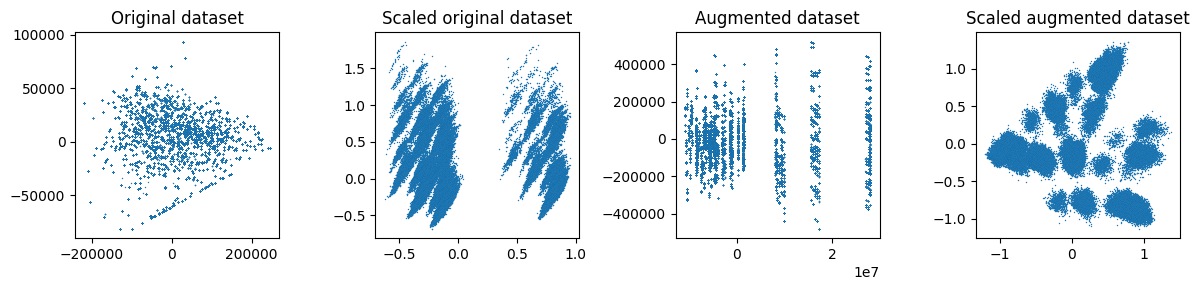

In [6]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df_init, remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df_init, remove_outliers=True, with_indicators=True)

print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 19

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


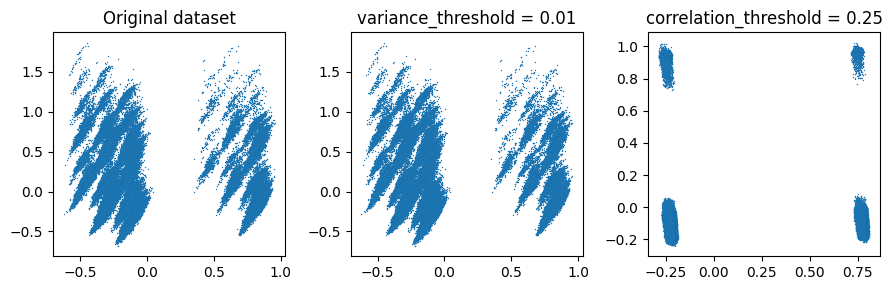

In [68]:
var_thr = 0.01
reduced_orig_var = features_reduction_var(df_orig_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_orig_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig_var.columns)}')
print(reduced_orig_var.columns)

corr_thr = 0.25
reduced_orig = features_reduction_corr(reduced_orig_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig.columns)}')
print(reduced_orig.columns)

pca_orig_v = perform_PCA(df=reduced_orig_var, n_components=2)
pca_orig_c = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_orig_v[:, 0], pca_orig_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_orig_c[:, 0], pca_orig_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Initial n_cols = 51

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 48
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'state_population', 'p_males',
       'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed',
       'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_

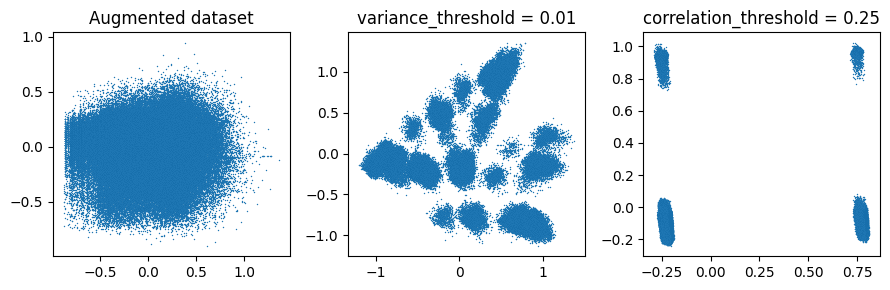

In [69]:
var_thr = 0.01
reduced_var = features_reduction_var(df_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_var.columns)}')
print(reduced_var.columns)

corr_thr = 0.25
reduced = features_reduction_corr(reduced_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced.columns)}')
print(reduced.columns)

pca_v = perform_PCA(df=reduced_var, n_components=2)
pca_c = perform_PCA(df=reduced, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

# K-means

### K-means experiments on the original dataset (without outliers)

#### K-means on the full original dataset

In [9]:
k_min = 2
k_max = 20

models = k_means(df_orig_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:39<00:00,  5.23s/it]


k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


k = 3


100%|██████████| 5/5 [00:01<00:00,  4.62it/s]


k = 4


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


k = 5


100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


k = 6


100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


k = 7


100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


k = 8


100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


k = 9


100%|██████████| 5/5 [00:01<00:00,  4.59it/s]


k = 10


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


k = 11


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


k = 12


100%|██████████| 5/5 [00:01<00:00,  4.69it/s]


k = 13


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


k = 14


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


k = 15


100%|██████████| 5/5 [00:01<00:00,  4.59it/s]


k = 16


100%|██████████| 5/5 [00:01<00:00,  4.48it/s]


k = 17


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


k = 18


100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


k = 19


100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


k = 20


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


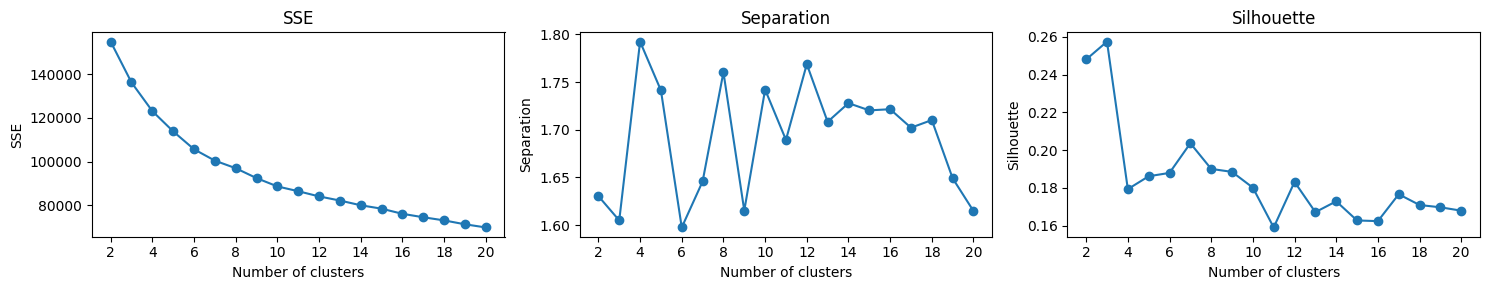

In [10]:
scores_dict = scores(models=models, df=df_orig_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=5)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:09<00:00,  3.28s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


k = 4


100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


k = 5


100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


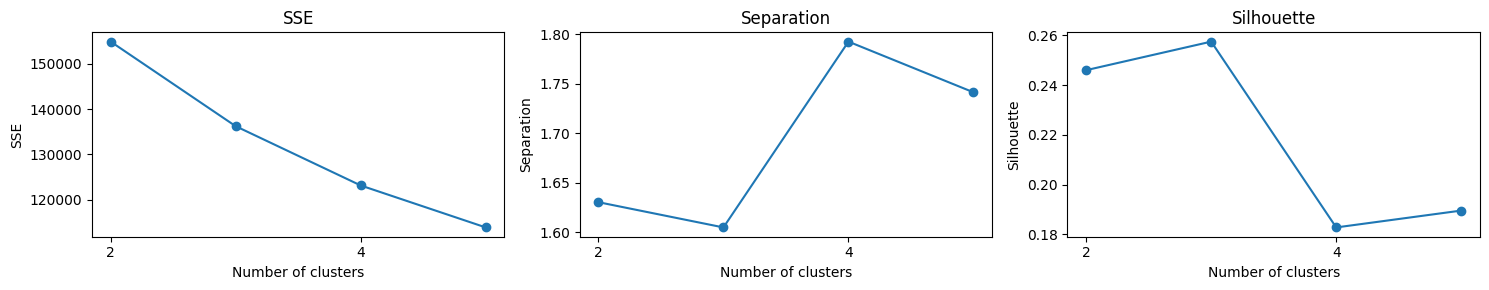


k = 2:
SSE = 154895.28685437012
Separation = 1.6304716570456599
Silhouette = 0.24600553842187312

k = 3:
SSE = 136206.3792058879
Separation = 1.6050108948413984
Silhouette = 0.25747682501553265

k = 4:
SSE = 123109.9414815558
Separation = 1.7924004077088809
Silhouette = 0.1828219658332896

k = 5:
SSE = 113837.36521123808
Separation = 1.7412798840986983
Silhouette = 0.18959510793231618


In [11]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_orig_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [12]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_orig_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_orig = models[best_k]

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:35<00:00, 11.78s/it]


Best mean silhouette score for k = 3:
SSE = 136206.3792058879
Separation = 1.6050108948413984
Silhouette = 0.256690769527583


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


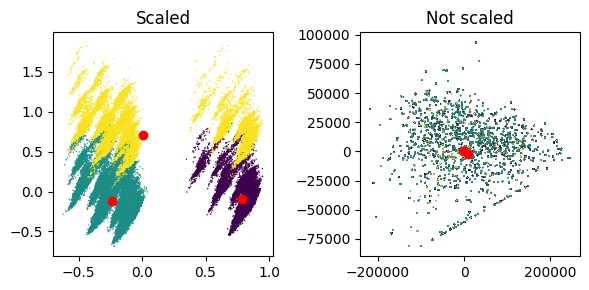

Cluster 0: 38523 points
Cluster 1: 125972 points
Cluster 2: 26482 points


In [13]:
labels = best_model_orig.labels_
centroids = best_model_orig.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_orig_s, centroids=centroids, n_components=2)

orig_points = df_orig
orig_centroids = scaler_orig.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced original dataset

In [70]:
k_min = 2
k_max = 20

models = k_means(df=reduced_orig, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:29<00:00,  4.71s/it]


k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


k = 3


100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


k = 4


100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


k = 5


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


k = 6


100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


k = 7


100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


k = 8


100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


k = 9


100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


k = 10


100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


k = 11


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


k = 12


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


k = 13


100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


k = 14


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


k = 15


100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


k = 16


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


k = 17


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


k = 18


100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


k = 19


100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


k = 20


100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


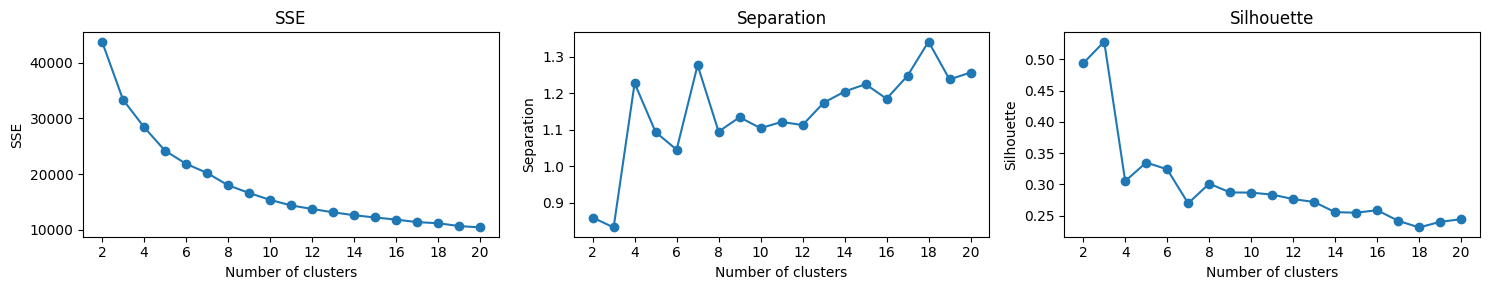

In [71]:
scores_dict = scores(models=models, df=reduced_orig, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=5)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:10<00:00,  3.42s/it]


k = 3


100%|██████████| 3/3 [00:09<00:00,  3.09s/it]


k = 4


100%|██████████| 3/3 [00:10<00:00,  3.55s/it]


k = 5


100%|██████████| 3/3 [00:08<00:00,  2.90s/it]


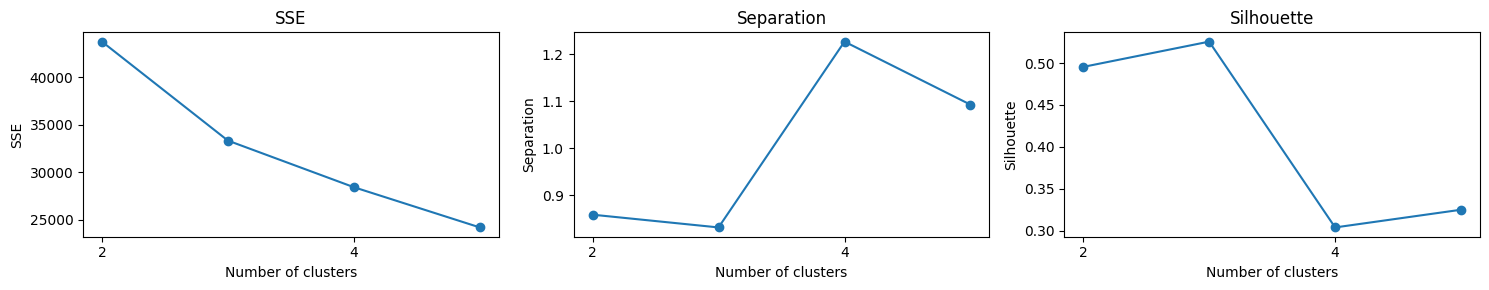


k = 2:
SSE = 43748.331314141134
Separation = 0.8589341949521003
Silhouette = 0.49545578418178843

k = 3:
SSE = 33337.49599621496
Separation = 0.8318175058975704
Silhouette = 0.5256384222770025

k = 4:
SSE = 28434.929253650065
Separation = 1.227086913847262
Silhouette = 0.303859449924712

k = 5:
SSE = 24203.457974352947
Separation = 1.0929616630490195
Silhouette = 0.324995711826062


In [72]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced_orig, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [73]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_orig, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_r_orig = models[best_k]

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:37<00:00, 12.46s/it]


Best mean silhouette score for k = 3:
SSE = 33337.49599621496
Separation = 0.8318175058975704
Silhouette = 0.5283461152381865


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


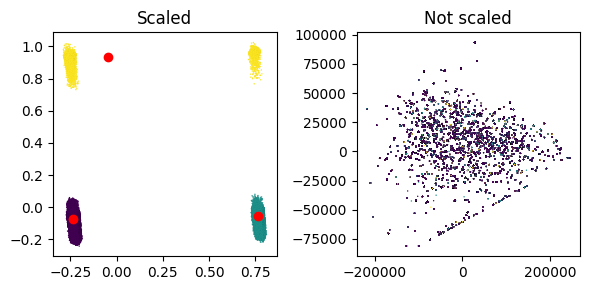

Cluster 0: 135320 points
Cluster 1: 42394 points
Cluster 2: 13263 points


In [74]:
labels = best_model_r_orig.labels_
centroids = best_model_r_orig.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced_orig, centroids=centroids, n_components=2)

orig_points = df_orig

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

### K-means experiments on the augmented (i.e. with indicators) dataset (without outliers)

#### K-means on the full augmented dataset

In [19]:
k_min = 2
k_max = 20

models = k_means(df=df_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [02:51<00:00,  9.05s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  3.99it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  4.65it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  3.98it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


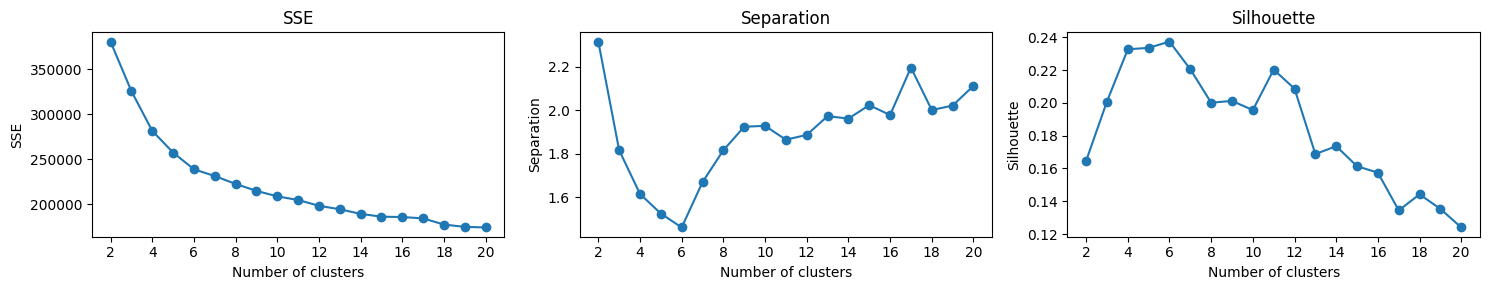

In [20]:
scores_dict = scores(models=models, df=df_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 4


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


k = 5


100%|██████████| 3/3 [00:11<00:00,  3.71s/it]


k = 6


100%|██████████| 3/3 [00:08<00:00,  2.71s/it]


k = 7


100%|██████████| 3/3 [00:09<00:00,  3.27s/it]


k = 8


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


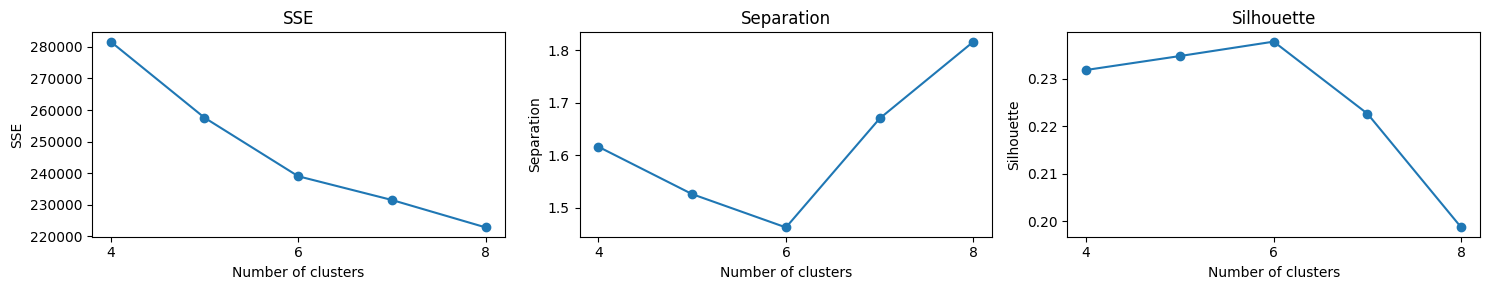


k = 4:
SSE = 281680.0775740807
Separation = 1.6162905125544866
Silhouette = 0.23188125001310014

k = 5:
SSE = 257573.4770180633
Separation = 1.5259768309441542
Silhouette = 0.2348201086406344

k = 6:
SSE = 239000.18445276262
Separation = 1.4624803654494887
Silhouette = 0.23785834400986317

k = 7:
SSE = 231464.50723682117
Separation = 1.6702990417240542
Silhouette = 0.2226637996201417

k = 8:
SSE = 222770.86344344175
Separation = 1.8167762231228979
Silhouette = 0.19869357978817867


In [21]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [22]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model = models[best_k]

k = 6


100%|██████████| 3/3 [00:39<00:00, 13.03s/it]


Best mean silhouette score for k = 6:
SSE = 239000.18445276262
Separation = 1.4624803654494887
Silhouette = 0.23558284496482326


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


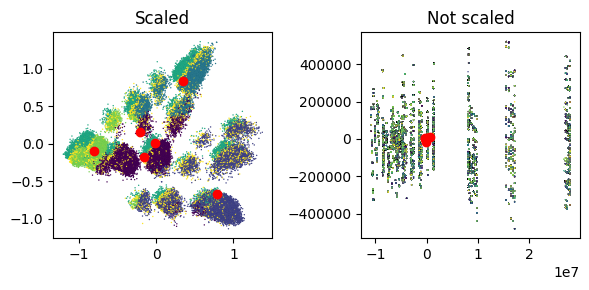

Cluster 0: 38195 points
Cluster 1: 35838 points
Cluster 2: 39245 points
Cluster 3: 12097 points
Cluster 4: 41515 points
Cluster 5: 24087 points


In [23]:
labels = best_model.labels_
centroids = best_model.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_s, centroids=centroids, n_components=2)

orig_points = df
orig_centroids = scaler.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced augmented dataset
(the same as with the reduced original dataset)

In [75]:
k_min = 2
k_max = 20

models = k_means(df=reduced, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:30<00:00,  4.74s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


k = 12


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


k = 17


100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


k = 20


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


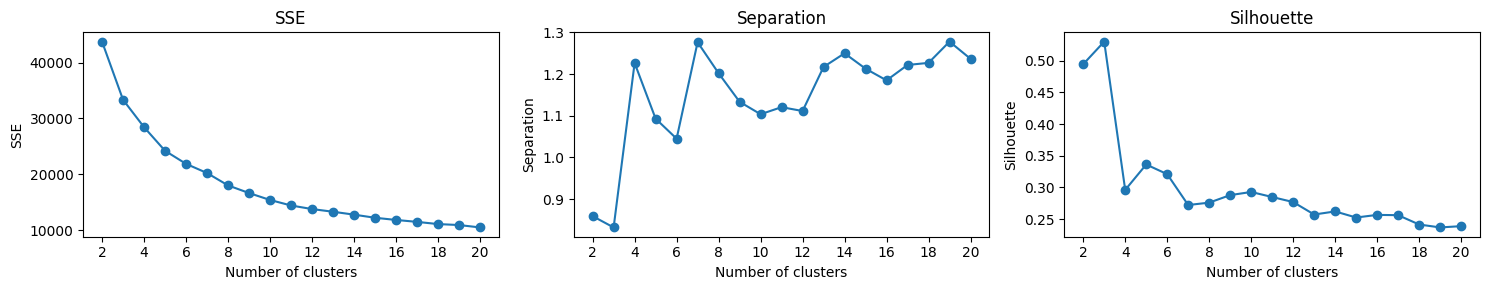

In [76]:
scores_dict = scores(models=models, df=reduced, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.51s/it]


k = 3


100%|██████████| 3/3 [00:14<00:00,  4.73s/it]


k = 4


100%|██████████| 3/3 [00:14<00:00,  4.99s/it]


k = 5


100%|██████████| 3/3 [00:14<00:00,  4.71s/it]


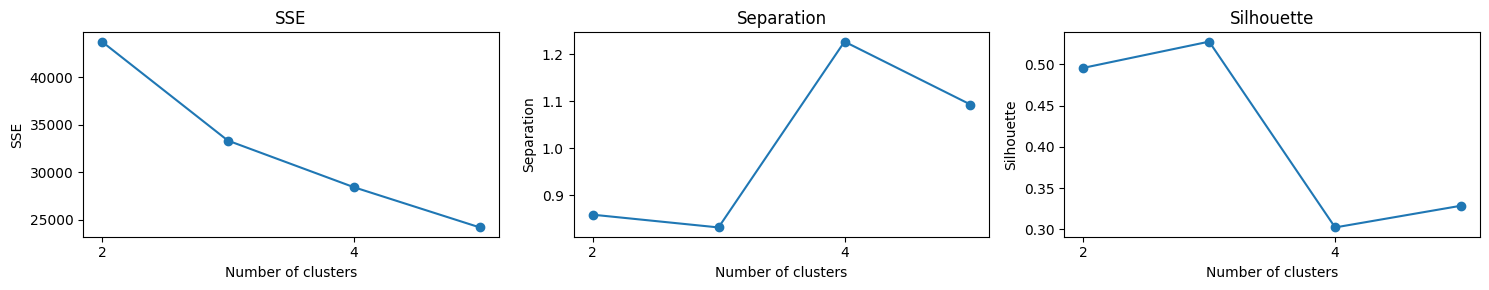


k = 2:
SSE = 43748.33131414113
Separation = 0.8589341949521003
Silhouette = 0.49562870151864313

k = 3:
SSE = 33337.49599621496
Separation = 0.8318175058975704
Silhouette = 0.5274564010315793

k = 4:
SSE = 28434.8939843104
Separation = 1.22677485455955
Silhouette = 0.3024437493050058

k = 5:
SSE = 24203.486304642327
Separation = 1.0930209231200774
Silhouette = 0.3287486259579872


In [77]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [78]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_r = models[best_k]

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:50<00:00, 16.70s/it]


Best mean silhouette score for k = 3:
SSE = 33337.49599621496
Separation = 0.8318175058975704
Silhouette = 0.5286048577643996


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


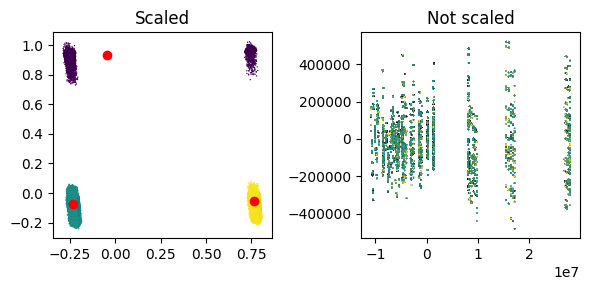

Cluster 0: 13263 points
Cluster 1: 135320 points
Cluster 2: 42394 points


In [79]:
labels = best_model_r.labels_
centroids = best_model_r.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced, centroids=centroids, n_components=2)

orig_points = df

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### + Trying with only indicators

Idicator dataset dimentions: (190977, 21)


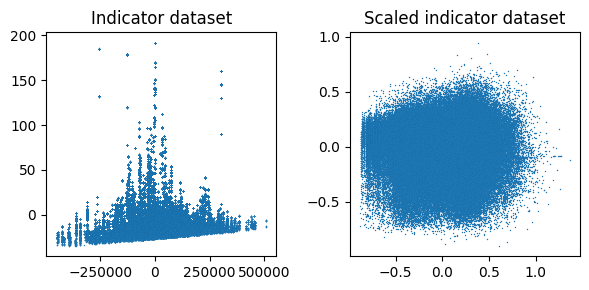

In [55]:
df_ind = df[['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER']]

scaler_ind = MinMaxScaler()
df_ind_s = scaler.fit_transform(df_ind)
df_ind_s = pd.DataFrame(df_ind_s, columns=df_ind.columns)

print(f'Idicator dataset dimentions: {df_ind.shape}')

pca = perform_PCA(df=df_ind, n_components=2)
pca_s = perform_PCA(df=df_ind_s, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Indicator dataset')

plt.subplot(1, 2, 2)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled indicator dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 21

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 21
Index(['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['month_cd_change_min_age_participants', 'month_cd_ratio_males',
       'mon

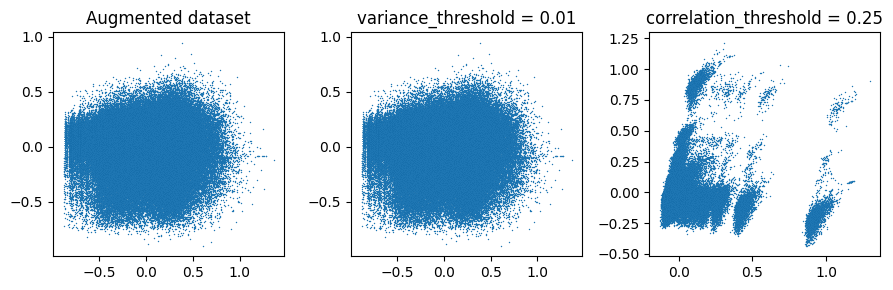

In [90]:
var_thr = 0.01
reduced_ind_var = features_reduction_var(df_ind_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_ind_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind_var.columns)}')
print(reduced_ind_var.columns)

corr_thr = 0.25
reduced_ind = features_reduction_corr(reduced_ind_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind.columns)}')
print(reduced_ind.columns)

pca_v = perform_PCA(df=reduced_ind_var, n_components=2)
pca_c = perform_PCA(df=reduced_ind, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

#### K-means on the full indicator dataset

In [82]:
k_min = 2
k_max = 20

models = k_means(df=df_ind_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [02:32<00:00,  8.02s/it]


k = 2


 33%|███▎      | 1/3 [00:00<00:00,  5.87it/s]

100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


k = 5


100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


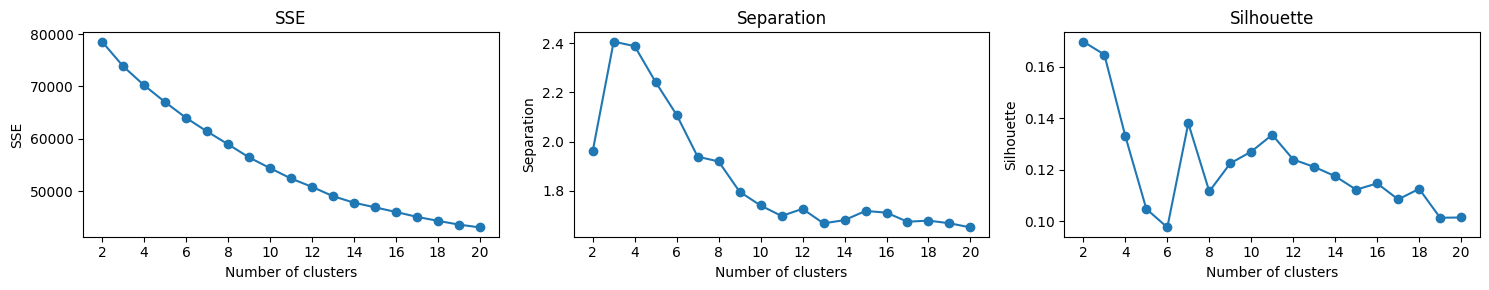

In [83]:
scores_dict = scores(models=models, df=df_ind_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:09<00:00,  3.16s/it]


k = 3


100%|██████████| 3/3 [00:08<00:00,  2.82s/it]


k = 4


100%|██████████| 3/3 [00:10<00:00,  3.35s/it]


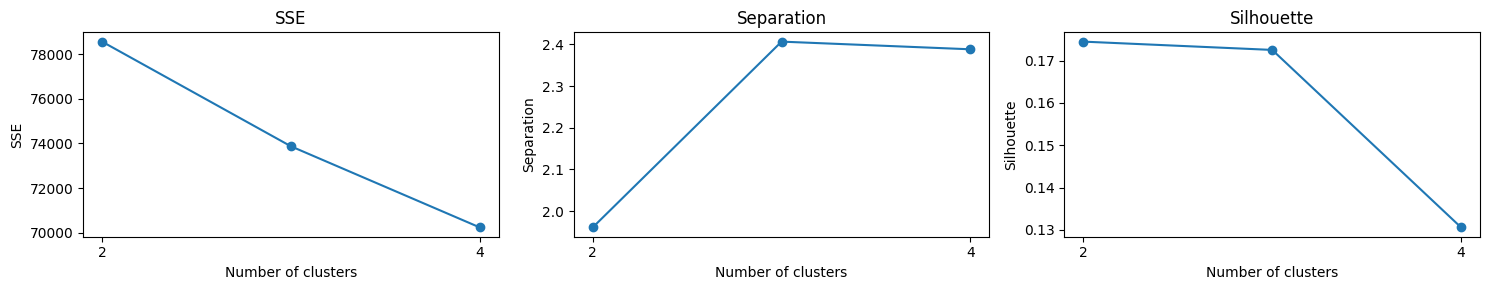


k = 2:
SSE = 78555.08447183856
Separation = 1.960731938366083
Silhouette = 0.1744699466722527

k = 3:
SSE = 73874.67941242876
Separation = 2.4067159646013927
Silhouette = 0.1725088199242086

k = 4:
SSE = 70246.2876341963
Separation = 2.388291961741112
Silhouette = 0.1305761125003501


In [84]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_ind_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [85]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_ind_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_ind = models[best_k]

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:38<00:00, 12.82s/it]


Best mean silhouette score for k = 2:
SSE = 78555.08447183856
Separation = 1.960731938366083
Silhouette = 0.17426908186416082


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


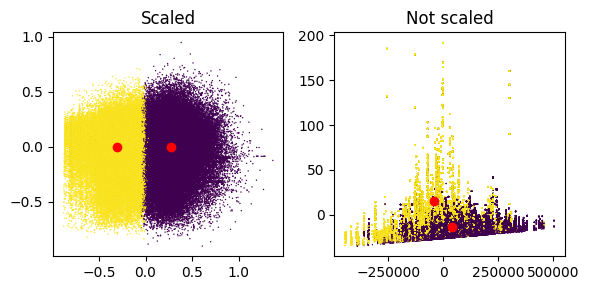

Cluster 0: 101330 points
Cluster 1: 89647 points


In [86]:
labels = best_model_ind.labels_
centroids = best_model_ind.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_ind_s, centroids=centroids, n_components=2)

orig_points = df_ind
orig_centroids = scaler.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced indicator dataset

In [91]:
k_min = 2
k_max = 20

models = k_means(df=reduced_ind, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:41<00:00,  5.36s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


k = 8


100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


k = 9


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


k = 13


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


k = 14


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  4.37it/s]


k = 16


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


k = 17


100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


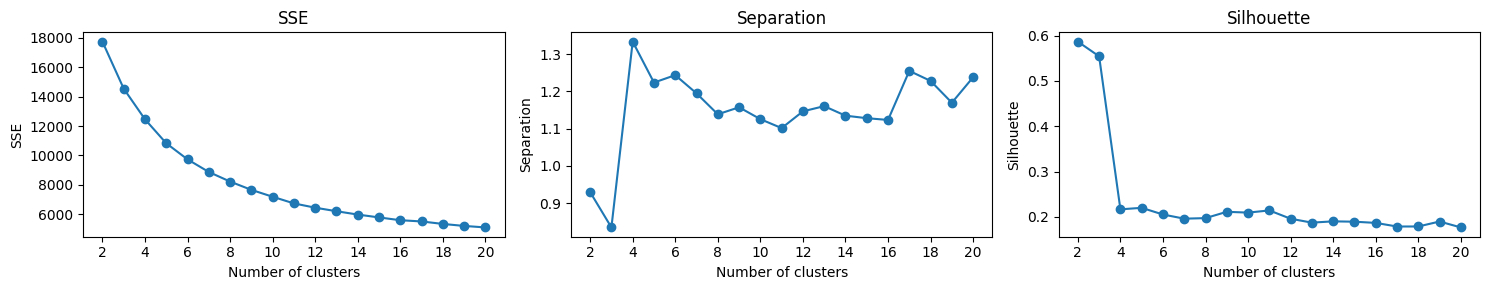

In [92]:
scores_dict = scores(models=models, df=reduced_ind, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


k = 3


100%|██████████| 3/3 [00:13<00:00,  4.58s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.59s/it]


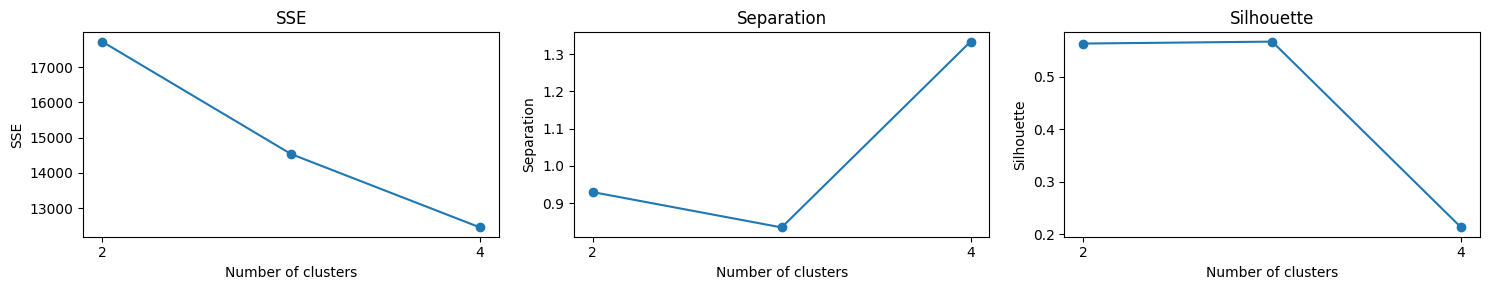


k = 2:
SSE = 17727.76424568076
Separation = 0.9293714274272848
Silhouette = 0.5634616293196923

k = 3:
SSE = 14536.677016371657
Separation = 0.8343748674959905
Silhouette = 0.5671527060764515

k = 4:
SSE = 12453.997600041988
Separation = 1.3337821763089106
Silhouette = 0.21336017669955756


In [93]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced_ind, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [94]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_ind, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

best_model_r_ind = models[best_k]

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:42<00:00, 14.22s/it]


Best mean silhouette score for k = 3:
SSE = 14536.677016371657
Separation = 0.8343748674959905
Silhouette = 0.5786278250019137


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


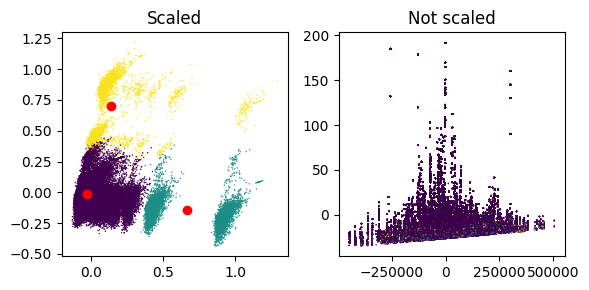

Cluster 0: 178842 points
Cluster 1: 6902 points
Cluster 2: 5233 points


In [95]:
labels = best_model_r_ind.labels_
centroids = best_model_r_ind.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced_ind, centroids=centroids, n_components=2)

orig_points = df_ind

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

## Analysis

#### Original data clustering

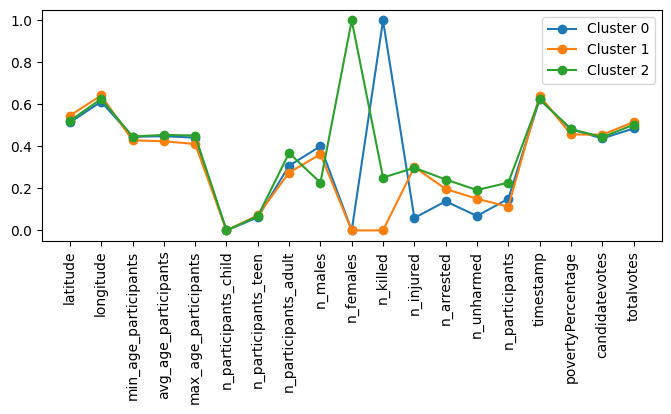

In [96]:
centers = best_model_orig.cluster_centers_
cols = df_orig.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

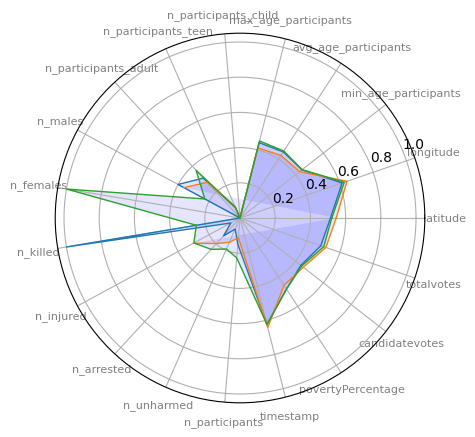

In [97]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [98]:
cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

df_c =  df_init[df_init['OUTLIER'] == 0]
df_c = df_c[cat_cols]

In [99]:
party_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         23238       15285
1         72259       53713
2         14017       12465

In [100]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.603224    0.396776
1  0.573612    0.426388
2  0.529303    0.470697

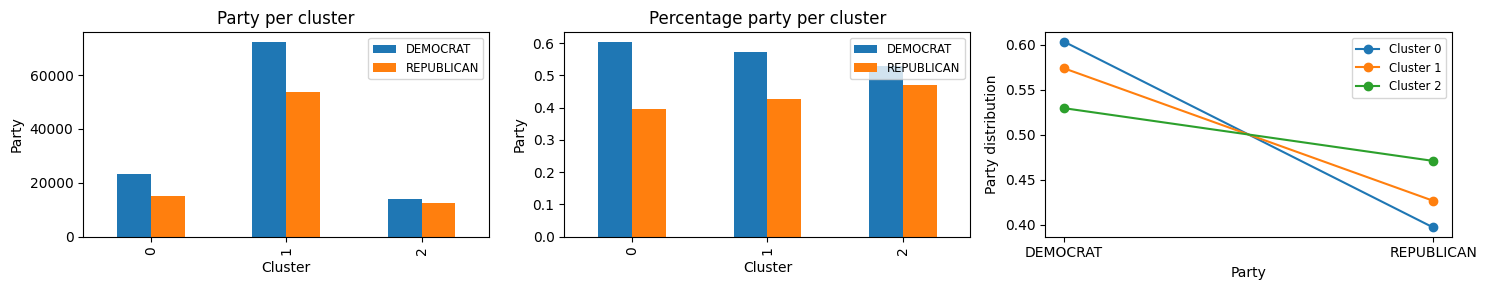

In [102]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [103]:
day_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         1336  1189  1193  1303  1280  1258  1237  1256  1202  1289  ...   
1         4662  4031  4096  4064  4192  4071  4091  4064  4018  3936  ...   
2          962   810   844   849   879   900   843   869   847   787  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         1204  1330  1236  1264  1294  1308  1297  1186  1163   800  
1         4005  4055  3944  4281  4163  4187  4154  3952  3801  2496  
2          872   851   876   930   896   892   872   805   842   520  

[3 rows x 31 columns]

In [104]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.034681  0.030865  0.030969  0.033824  0.033227  0.032656  0.032111   
1  0.037008  0.031999  0.032515  0.032261  0.033277  0.032317  0.032475   
2  0.036327  0.030587  0.031871  0.032060  0.033192  0.033985  0.031833   

         8         9         10  ...        22        23        24        25  \
0  0.032604  0.031202  0.033461  ...  0.031254  0.034525  0.032085  0.032812   
1  0.032261  0.031896  0.031245  ...  0.031793  0.032190  0.031309  0.033984   
2  0.032815  0.031984  0.029718  ...  0.032928  0.032135  0.033079  0.035118   

         26        27        28        29        30        31  
0  0.033590  0.033954  0.033668  0.030787  0.030190  0.020767  
1  0.033047  0.033238  0.032976  0.031372  0.030173  0.019814  
2  0.033834  0.033683  0.032928  0.030398  0.031795  0.019636  

[3 rows x 31 columns]

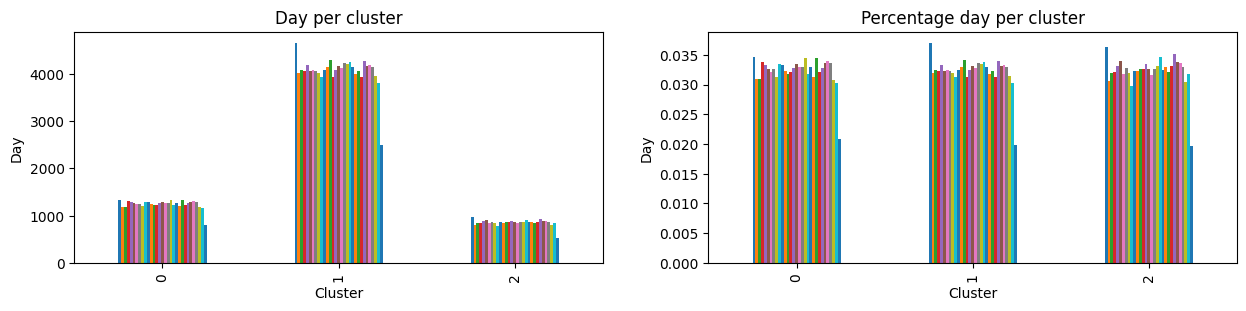

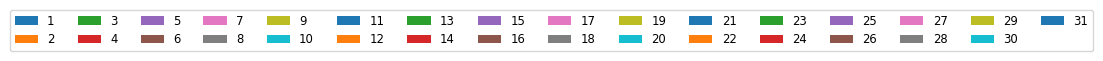

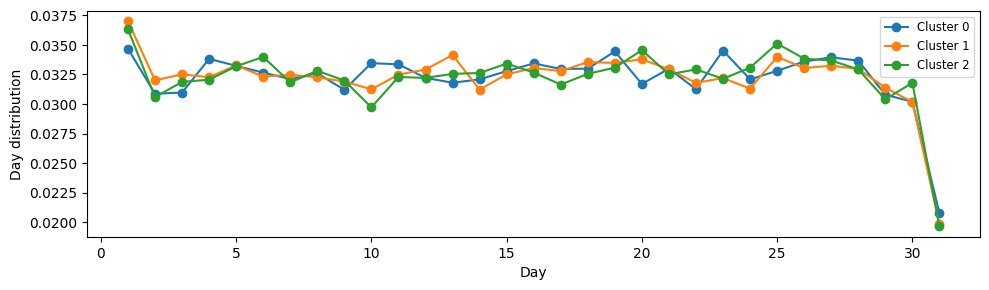

In [105]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [106]:
month_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3     4      5     6      7      8      9   \
row_0                                                                     
0            3761   3019   3547  2805   3182  3024   3395   3354   3049   
1           12148  10079  12196  9678  10234  9509  10743  11050  10240   
2            2601   2145   2532  2057   2184  2031   2313   2275   2119   

date_month     10    11     12  
row_0                           
0            3072  3084   3231  
1           10564  9364  10167  
2            2182  1925   2118

In [107]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097630  0.078369  0.092075  0.072814  0.082600  0.078499  0.088129   
1  0.096434  0.080010  0.096815  0.076827  0.081240  0.075485  0.085281   
2  0.098218  0.080998  0.095612  0.077675  0.082471  0.076694  0.087342   

         8         9         10        11        12  
0  0.087065  0.079148  0.079745  0.080056  0.083872  
1  0.087718  0.081288  0.083860  0.074334  0.080708  
2  0.085907  0.080017  0.082396  0.072691  0.079979

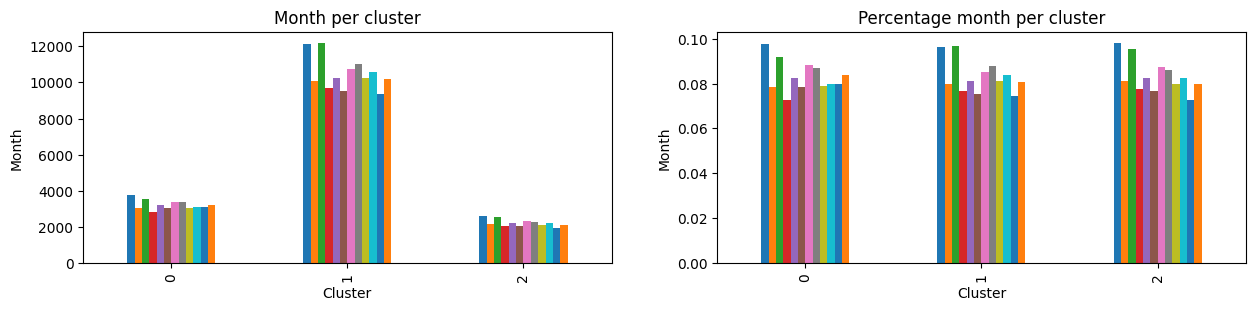

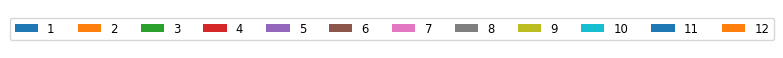

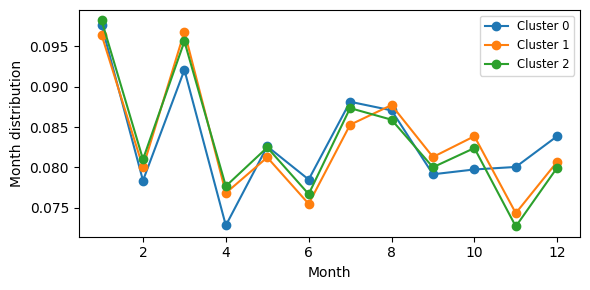

In [108]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [109]:
year_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              15    7104    8365   10172   10522    2345
1              22   19915   25436   35272   37173    8154
2               4    4773    5621    7247    7237    1600

In [110]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000389  0.184409  0.217143  0.264050  0.273136  0.060873
1  0.000175  0.158091  0.201918  0.279999  0.295089  0.064729
2  0.000151  0.180236  0.212257  0.273658  0.273280  0.060418

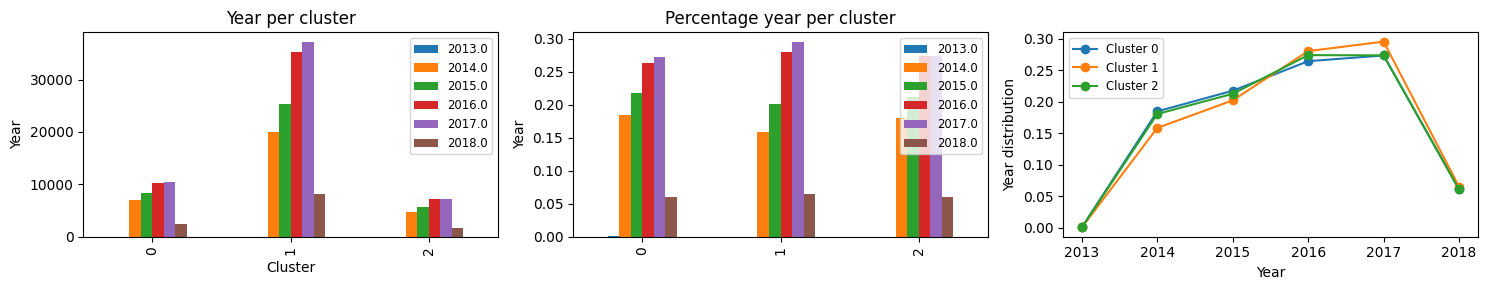

In [111]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [112]:
state_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         1129      21      639       477        2507       603          318   
1         2485     113      967      1502        6653      1837         2160   
2          723      23      304       433        1130       425          297   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           177     2396     1578  ...            74       1213   2638   169   
1          1107     7190     4433  ...           355       3997   5308   551   
2           151     1643     1245  ...            61        938   1584   132   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           39       963         526            199        732       87  
1          275      3234        1845            915       2845      287  
2           71       653         452            211        616       77  

[3 rows x 50 columns]

In [113]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.029307  0.000545  0.016587  0.012382    0.065078  0.015653     0.008255   
1  0.019727  0.000897  0.007676  0.011923    0.052813  0.014583     0.017147   
2  0.027302  0.000869  0.011479  0.016351    0.042670  0.016049     0.011215   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.004595  0.062197  0.040963  ...      0.001921   0.031488  0.068479   
1  0.008788  0.057076  0.035190  ...      0.002818   0.031729  0.042136   
2  0.005702  0.062042  0.047013  ...      0.002303   0.035420  0.059814   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004387  0.001012  0.024998    0.013654       0.005166   0.019002   
1  0.004374  0.002183  0.025672    0.014646       0.007264   0.022584   
2  0.004985  0.002681  0.024658    0.017068       0.007968   0.023261   

    WYOMING  
0  0.002258  
1  0.002278  
2  0.002908  

[3 rows x 50 columns]

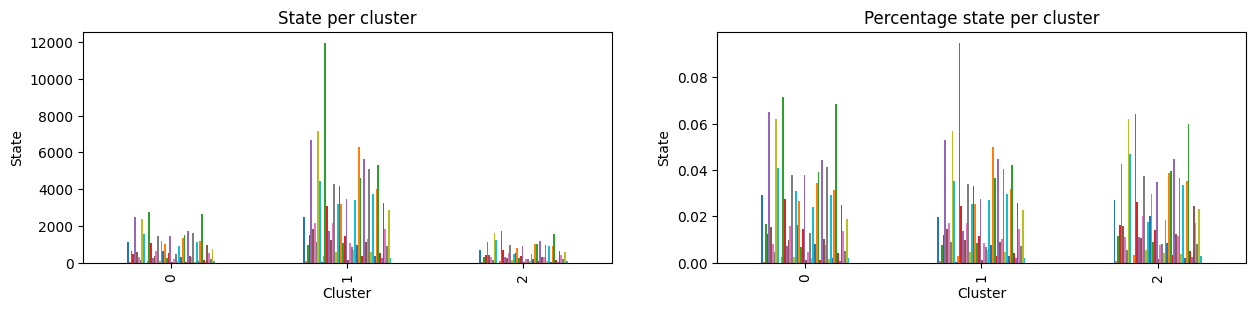

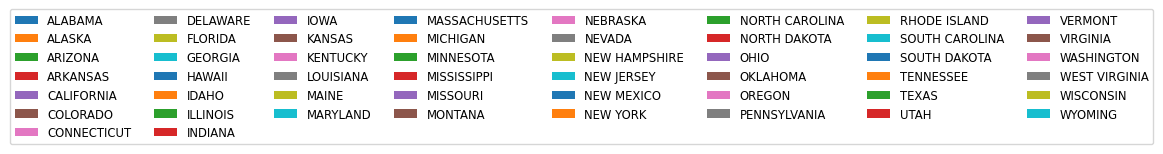

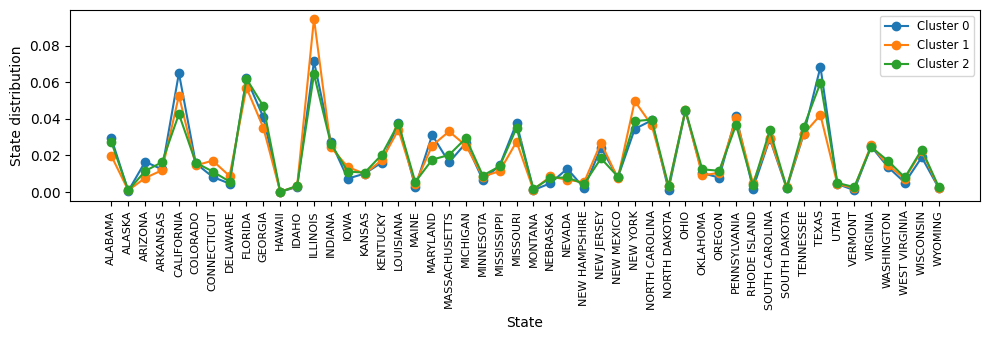

In [114]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [115]:
ic_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                     80                    9   
1                                   5100                  290   
2                                    691                   40   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  3   
1                                                 3                 16   
2                                                 1                  2   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                    9                             1   
1                                  177                            23   
2                                   72                             4   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      5                  0         5   
1                                     26                 65        46   
2                                      5                127        11   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        18  ...                  53   
1                                       707  ...                 141   
2                                       120  ...                  45   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0          80       27   
1                                     4               2         486        2   
2                                     0               1          94        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        5         443                0   
1                                       50        1276                4   
2                                       16         279                1   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      31                       0  
1                                     995                       1  
2                                     109                       0  

[3 rows x 49 columns]

In [116]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.002077             0.000234                  0.000000   
1       0.040485             0.002302                  0.000024   
2       0.026093             0.001510                  0.000038   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000078     0.000234                      0.000026   
1           0.000127     0.001405                      0.000183   
2           0.000076     0.002719                      0.000151   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000130           0.000000  0.000130          0.000467  ...   
1       0.000206           0.000516  0.000365          0.005612  ...   
2       0.000189           0.004796  0.000415          0.004531  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001376      0.000000        0.000000    0.002077  0.000701   
1            0.001119      0.000032        0.000016    0.003858  0.000016   
2            0.001699      0.000000        0.000038    0.003550  0.000038   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000130    0.011500         0.000000        0.000805   
1         0.000397    0.010129         0.000032        0.007899   
2         0.000604    0.010535         0.000038        0.004116   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000008  
2                0.000000  

[3 rows x 49 columns]

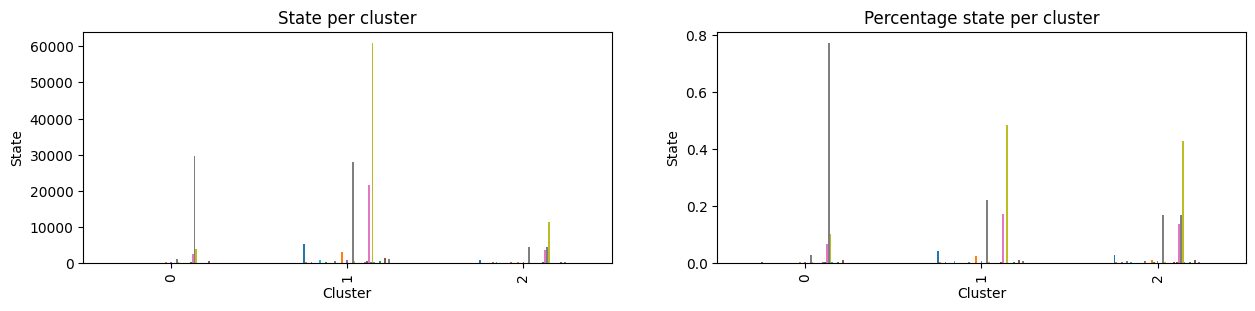

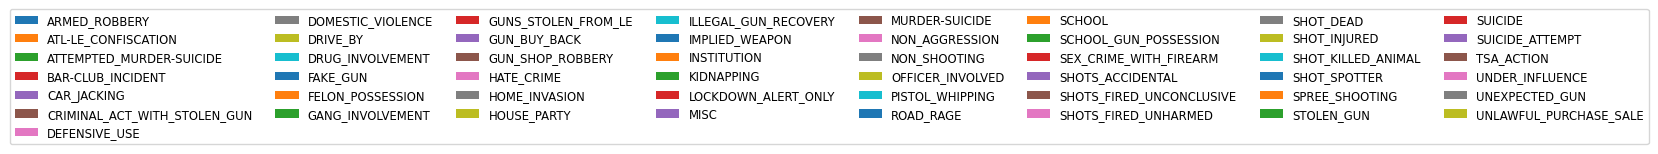

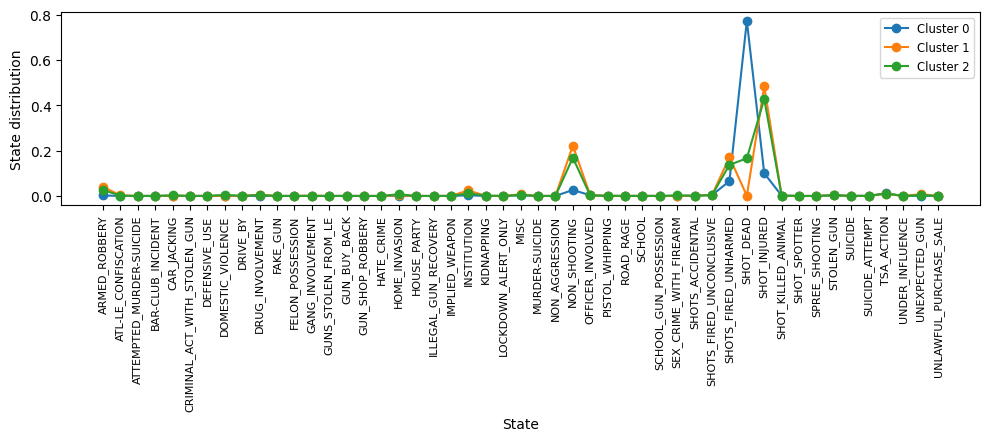

In [117]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Reduced original data clustring

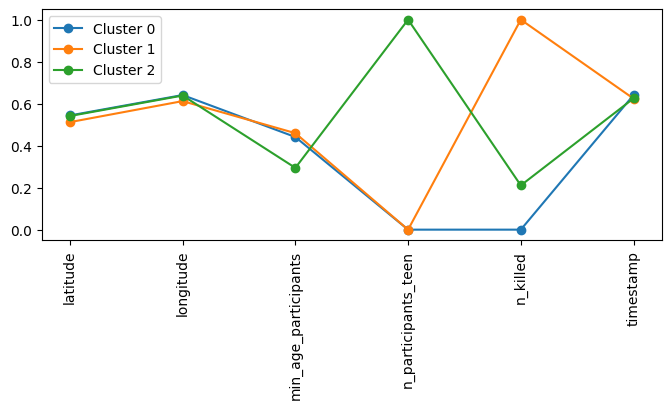

In [118]:
centers = best_model_r_orig.cluster_centers_
cols = reduced_orig.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

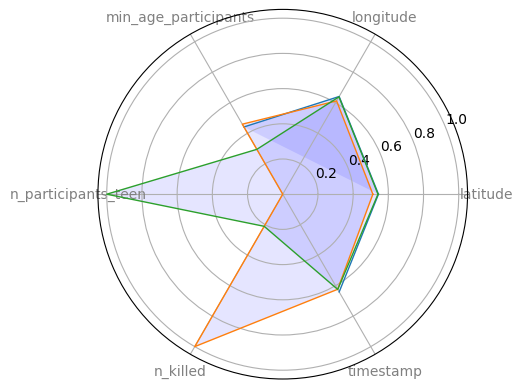

In [119]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [120]:
party_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         76489       58831
1         25096       17298
2          7929        5334

In [121]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.565245    0.434755
1  0.591971    0.408029
2  0.597829    0.402171

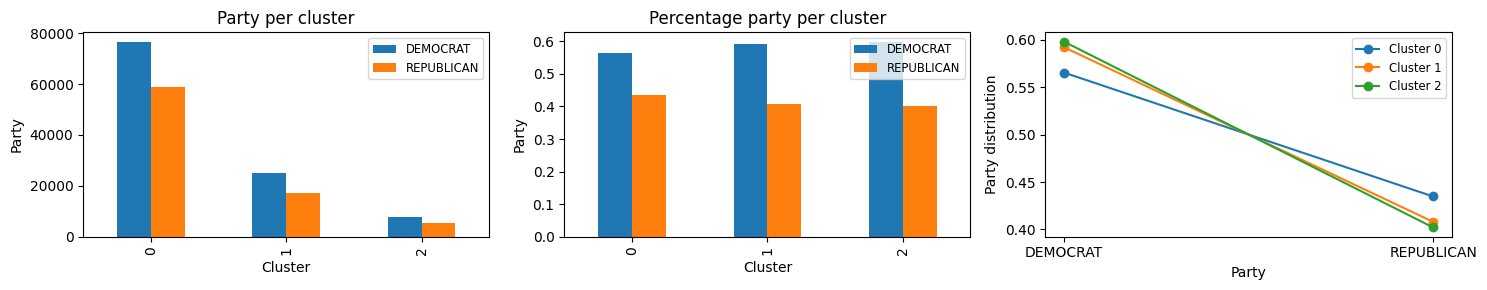

In [122]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [123]:
day_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         4990  4292  4384  4381  4495  4361  4376  4385  4277  4212  ...   
1         1482  1313  1346  1426  1399  1416  1374  1376  1339  1394  ...   
2          488   425   403   409   457   452   421   428   451   406  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         4354  4346  4264  4633  4493  4514  4474  4227  4097  2699  
1         1329  1457  1368  1408  1435  1447  1415  1300  1309   878  
2          398   433   424   434   425   426   434   416   400   239  

[3 rows x 31 columns]

In [125]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036876  0.031717  0.032397  0.032375  0.033218  0.032227  0.032338   
1  0.034958  0.030971  0.031750  0.033637  0.033000  0.033401  0.032410   
2  0.036794  0.032044  0.030385  0.030838  0.034457  0.034080  0.031742   

         8         9         10  ...        22        23        24        25  \
0  0.032405  0.031607  0.031126  ...  0.032176  0.032116  0.031510  0.034237   
1  0.032457  0.031585  0.032882  ...  0.031349  0.034368  0.032269  0.033212   
2  0.032270  0.034004  0.030611  ...  0.030008  0.032647  0.031969  0.032723   

         26        27        28        29        30        31  
0  0.033203  0.033358  0.033062  0.031237  0.030276  0.019945  
1  0.033849  0.034132  0.033377  0.030665  0.030877  0.020710  
2  0.032044  0.032119  0.032723  0.031365  0.030159  0.018020  

[3 rows x 31 columns]

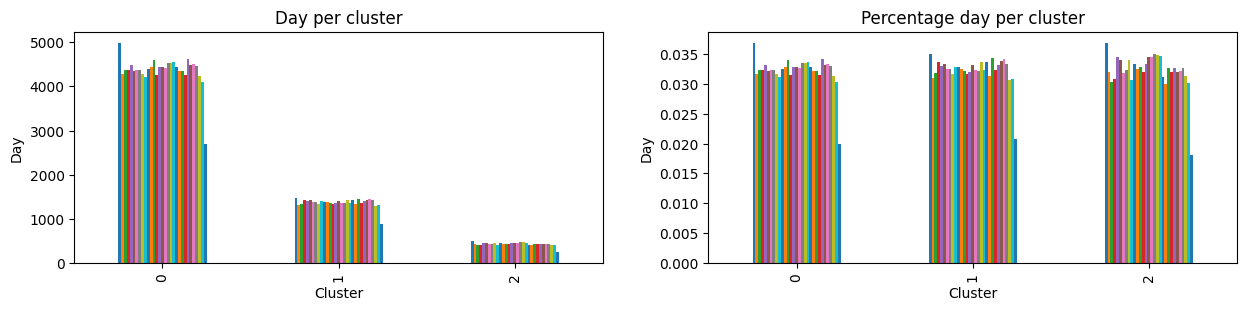

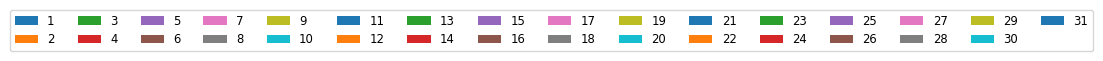

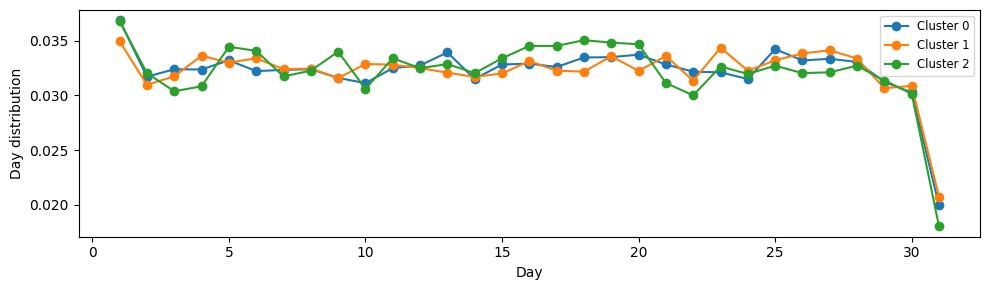

In [126]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [127]:
month_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0           13097  10781  13107  10415  10974  10231  11607  11904  11012   
1            4126   3361   3919   3099   3513   3333   3717   3641   3338   
2            1287   1101   1249   1026   1113   1000   1127   1134   1058   

date_month     10    11     12  
row_0                           
0           11306  9980  10906  
1            3420  3354   3573  
2            1092  1039   1037

In [128]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096785  0.079670  0.096859  0.076966  0.081097  0.075606  0.085774   
1  0.097325  0.079280  0.092442  0.073100  0.082865  0.078620  0.087678   
2  0.097037  0.083013  0.094172  0.077358  0.083918  0.075398  0.084973   

         8         9         10        11        12  
0  0.087969  0.081377  0.083550  0.073751  0.080594  
1  0.085885  0.078738  0.080672  0.079115  0.084281  
2  0.085501  0.079771  0.082334  0.078338  0.078187

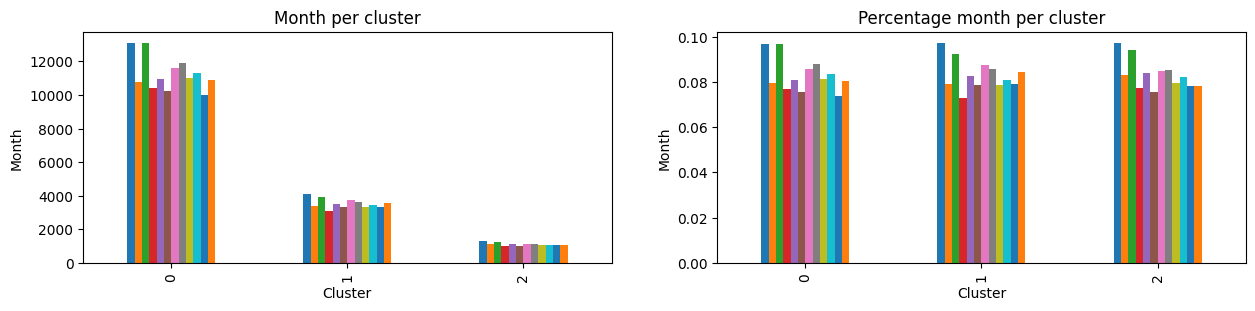

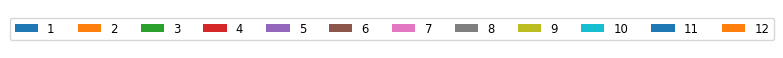

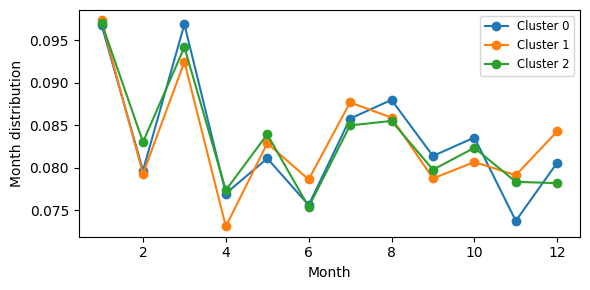

In [129]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [130]:
year_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              23   21525   27366   38030   39705    8671
1              16    7817    9187   11253   11530    2591
2               2    2450    2869    3408    3697     837

In [131]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000170  0.159067  0.202232  0.281038  0.293416  0.064078
1  0.000377  0.184389  0.216705  0.265439  0.271972  0.061117
2  0.000151  0.184724  0.216316  0.256955  0.278745  0.063108

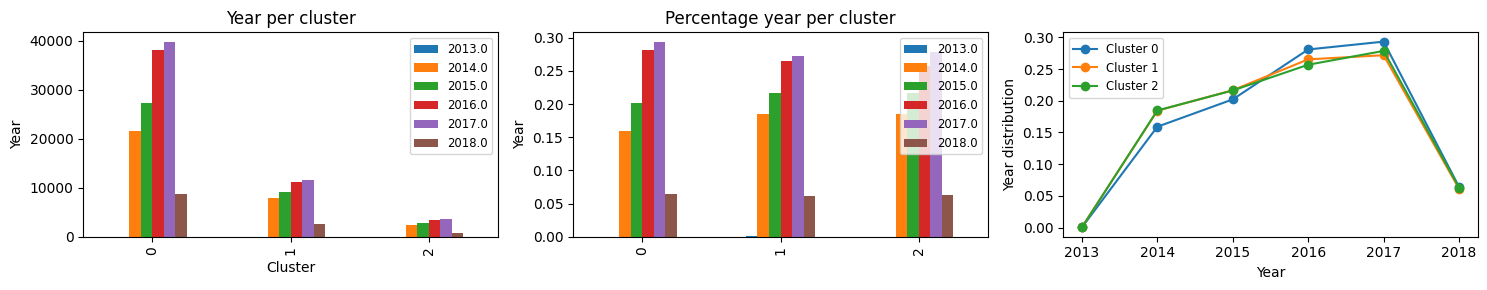

In [133]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [134]:
state_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         2773     129     1055      1712        6975      2038         2290   
1         1308      23      741       527        2674       654          339   
2          256       5      114       173         641       173          146   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1114     7761     4970  ...           375       4305   5895   603   
1           188     2648     1772  ...            82       1346   3014   186   
2           133      820      514  ...            33        497    621    63   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          320      3385        2043           1028       3063      330  
1           54      1051         586            244        823      101  
2           11       414         194             53        307       20  

[3 rows x 50 columns]

In [135]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.020492  0.000953  0.007796  0.012651    0.051544  0.015061     0.016923   
1  0.030853  0.000543  0.017479  0.012431    0.063075  0.015427     0.007996   
2  0.019302  0.000377  0.008595  0.013044    0.048330  0.013044     0.011008   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.008232  0.057353  0.036728  ...      0.002771   0.031813  0.043563   
1  0.004435  0.062462  0.041798  ...      0.001934   0.031750  0.071095   
2  0.010028  0.061826  0.038754  ...      0.002488   0.037473  0.046822   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004456  0.002365  0.025015    0.015098       0.007597   0.022635   
1  0.004387  0.001274  0.024791    0.013823       0.005756   0.019413   
2  0.004750  0.000829  0.031215    0.014627       0.003996   0.023147   

    WYOMING  
0  0.002439  
1  0.002382  
2  0.001508  

[3 rows x 50 columns]

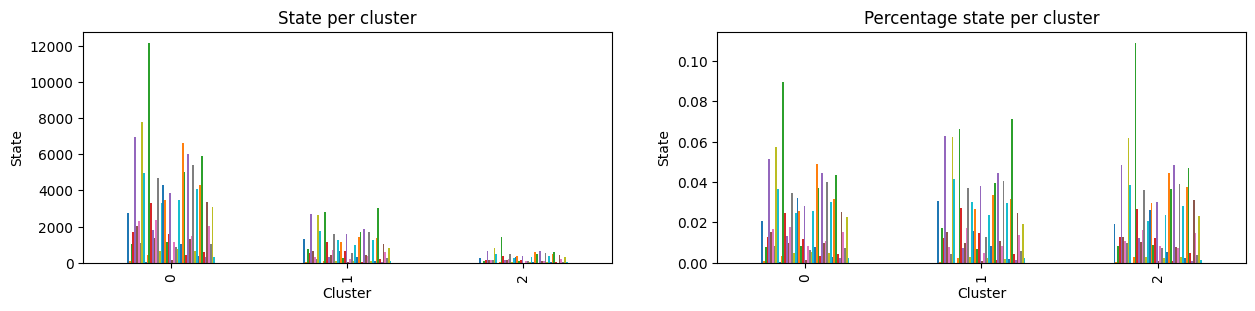

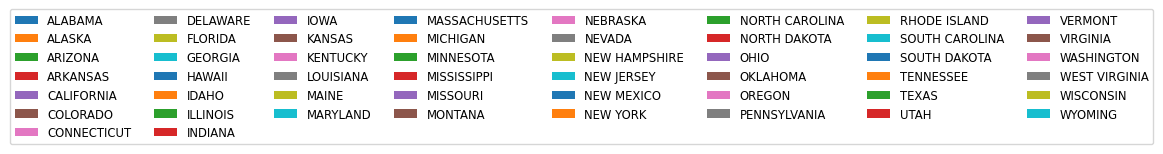

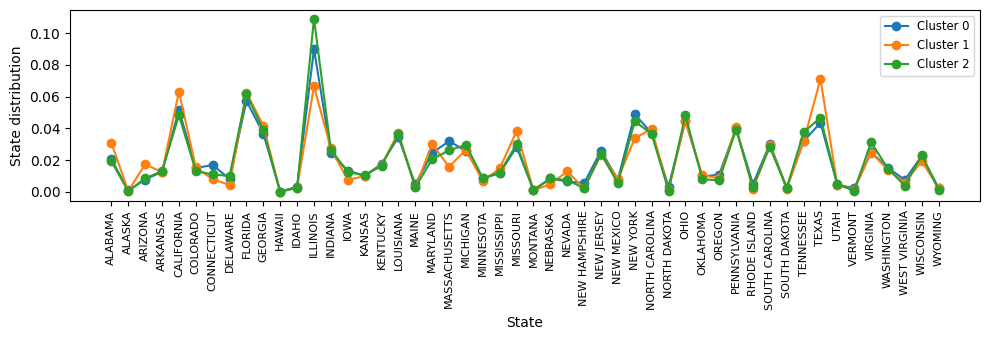

In [136]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [137]:
ic_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   5605                  307   
1                                     92                   12   
2                                    174                   20   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 4                 16   
1                                                 0                  3   
2                                                 0                  2   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  232                            27   
1                                    8                             1   
2                                   18                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     29                181        53   
1                                      5                  3         4   
2                                      2                  8         5   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       800  ...                 162   
1                                        20  ...                  68   
2                                        25  ...                   9   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     4               3         527        2   
1                                     0               0          84       27   
2                                     0               0          49        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       62        1376                5   
1                                        6         490                0   
2                                        3         132                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                    1035                       1  
1                                      32                       0  
2                                      68                       0  

[3 rows x 49 columns]

In [138]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.041420             0.002269                   0.00003   
1       0.002170             0.000283                   0.00000   
2       0.013119             0.001508                   0.00000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000118     0.001714                      0.000200   
1           0.000071     0.000189                      0.000024   
2           0.000151     0.001357                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000214           0.001338  0.000392          0.005912  ...   
1       0.000118           0.000071  0.000094          0.000472  ...   
2       0.000151           0.000603  0.000377          0.001885  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001197       0.00003        0.000022    0.003894  0.000015   
1            0.001604       0.00000        0.000000    0.001981  0.000637   
2            0.000679       0.00000        0.000000    0.003694  0.000075   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000458    0.010168         0.000037        0.007649   
1         0.000142    0.011558         0.000000        0.000755   
2         0.000226    0.009952         0.000000        0.005127   

   UNLAWFUL_PURCHASE_SALE  
0                0.000007  
1                0.000000  
2                0.000000  

[3 rows x 49 columns]

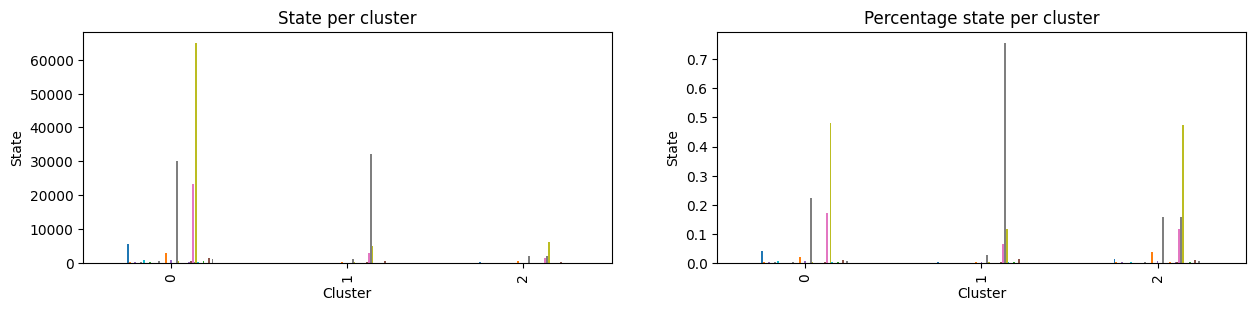

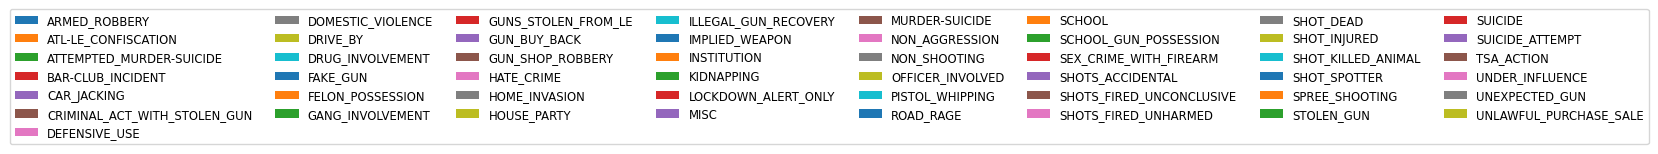

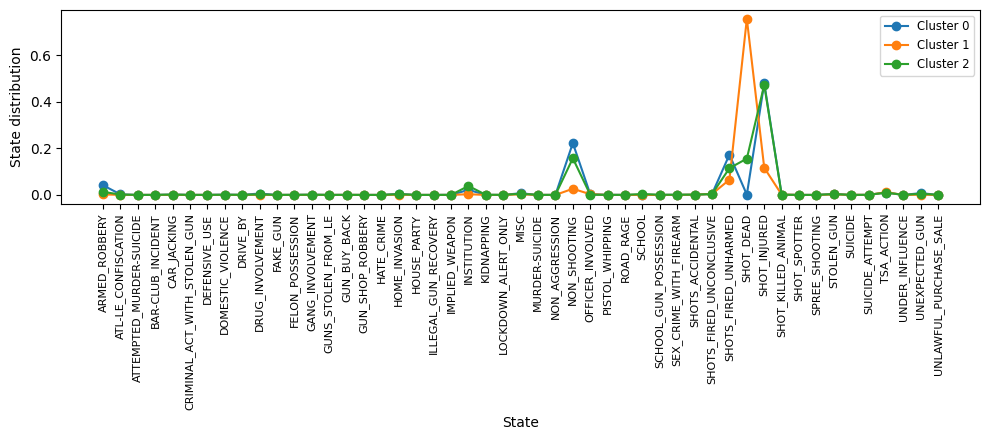

In [139]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Augmented data clustering

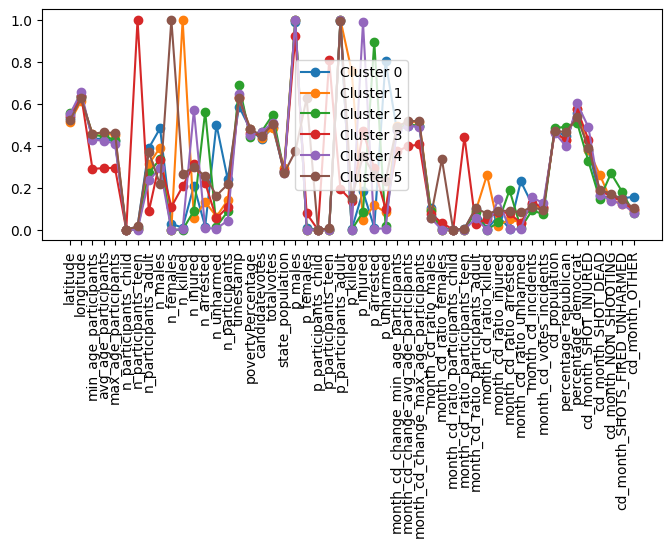

In [142]:
centers = best_model.cluster_centers_
cols = df.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

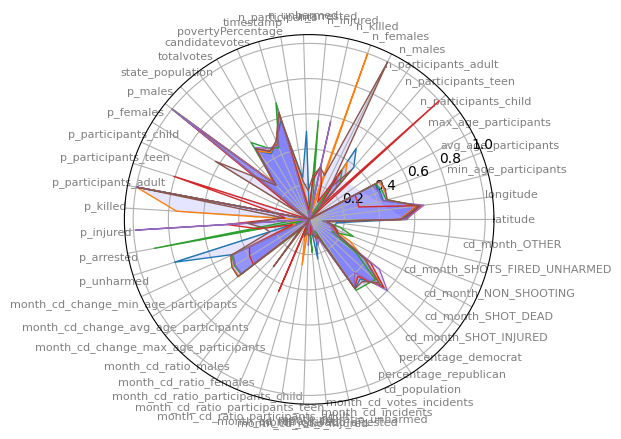

In [143]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [144]:
party_xt_pct = pd.crosstab(best_model.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         21507       16688
1         21623       14215
2         18858       20387
3          7262        4835
4         27612       13903
5         12652       11435

In [145]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.563084    0.436916
1  0.603354    0.396646
2  0.480520    0.519480
3  0.600314    0.399686
4  0.665109    0.334891
5  0.525263    0.474737

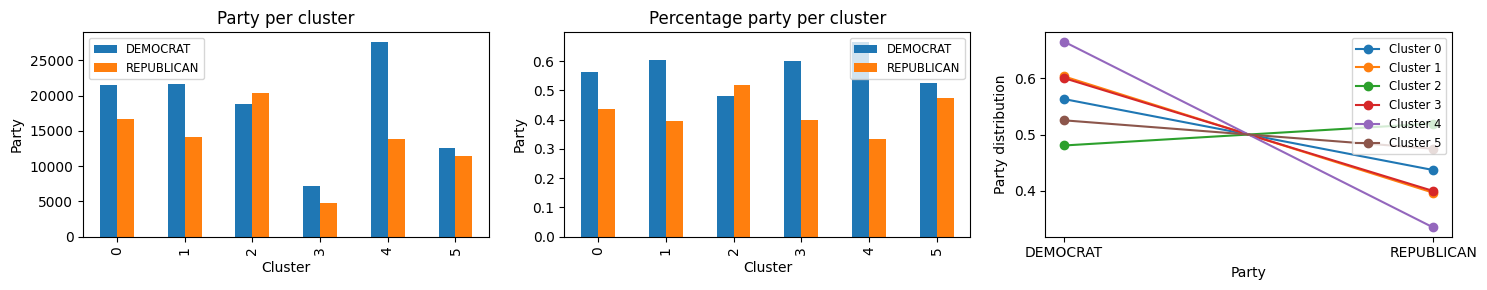

In [146]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [147]:
day_xt_pct = pd.crosstab(best_model.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         1346  1156  1225  1242  1284  1204  1257  1290  1171  1238  ...   
1         1253  1105  1122  1220  1189  1183  1154  1159  1121  1196  ...   
2         1522  1267  1271  1263  1307  1287  1252  1313  1300  1220  ...   
3          432   390   369   371   420   404   370   399   412   364  ...   
4         1525  1381  1368  1335  1362  1339  1369  1244  1296  1284  ...   
5          882   731   778   785   789   812   769   784   767   710  ...   

date_day    22    23    24    25    26    27    28    29    30   31  
row_0                                                                
0         1201  1203  1215  1344  1257  1247  1229  1263  1159  731  
1         1125  1240  1144  1175  1193  1235  1199  1096  1085  747  
2         1298  1258  1153  1217  1303  1307  1332  1181  1168  801  
3          357   398   379   402   392   393   409   370   362  208  
4         1306  1349  1377  1485  1389  1378  1352  1311  1266  850  
5          794   788   788   852   819   827   802   722   766  479  

[6 rows x 31 columns]

In [148]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.035240  0.030266  0.032072  0.032517  0.033617  0.031522  0.032910   
1  0.034963  0.030833  0.031308  0.034042  0.033177  0.033010  0.032200   
2  0.038782  0.032284  0.032386  0.032182  0.033304  0.032794  0.031902   
3  0.035711  0.032239  0.030503  0.030669  0.034719  0.033397  0.030586   
4  0.036734  0.033265  0.032952  0.032157  0.032807  0.032253  0.032976   
5  0.036617  0.030348  0.032300  0.032590  0.032756  0.033711  0.031926   

         8         9         10  ...        22        23        24        25  \
0  0.033774  0.030658  0.032413  ...  0.031444  0.031496  0.031810  0.035188   
1  0.032340  0.031280  0.033372  ...  0.031391  0.034600  0.031921  0.032786   
2  0.033456  0.033125  0.031087  ...  0.033074  0.032055  0.029380  0.031010   
3  0.032983  0.034058  0.030090  ...  0.029511  0.032901  0.031330  0.033231   
4  0.029965  0.031218  0.030929  ...  0.031459  0.032494  0.033169  0.035770   
5  0.032549  0.031843  0.029476  ...  0.032964  0.032715  0.032715  0.035372   

         26        27        28        29        30        31  
0  0.032910  0.032648  0.032177  0.033067  0.030344  0.019139  
1  0.033289  0.034461  0.033456  0.030582  0.030275  0.020844  
2  0.033202  0.033304  0.033941  0.030093  0.029762  0.020410  
3  0.032405  0.032487  0.033810  0.030586  0.029925  0.017194  
4  0.033458  0.033193  0.032567  0.031579  0.030495  0.020475  
5  0.034002  0.034334  0.033296  0.029975  0.031801  0.019886  

[6 rows x 31 columns]

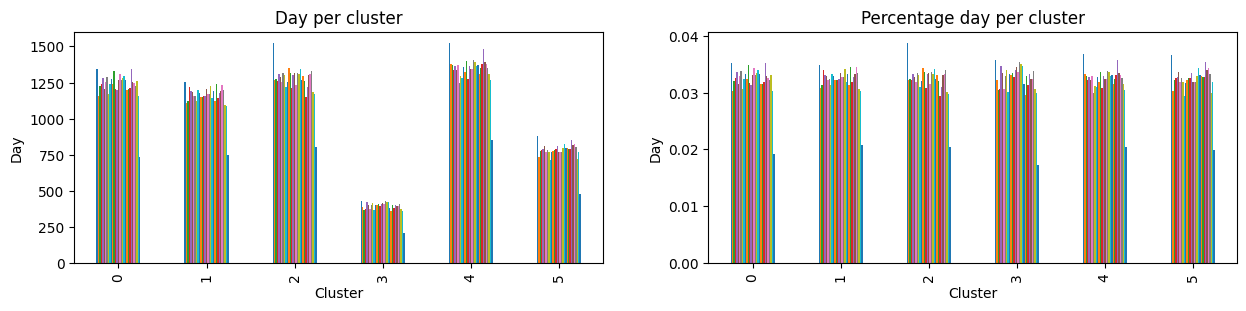

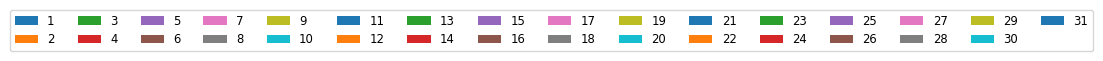

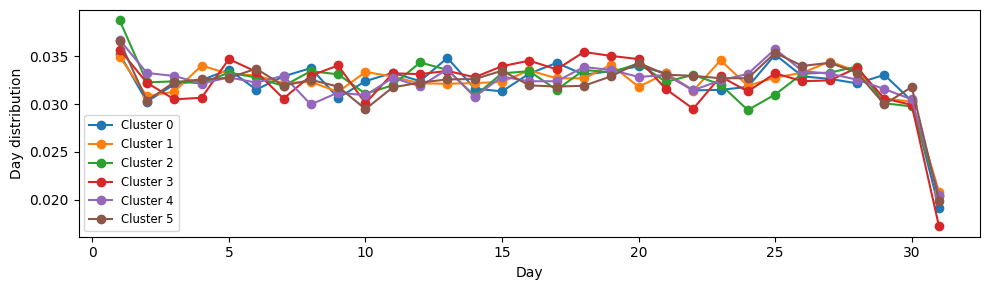

In [149]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [150]:
month_xt_pct = pd.crosstab(best_model.labels_, df_c['date_month'])
month_xt_pct

date_month    1     2     3     4     5     6     7     8     9     10    11  \
row_0                                                                          
0           3683  2997  3502  2852  3034  2874  3381  3473  3222  3419  2902   
1           3479  2797  3292  2596  2987  2821  3176  3119  2839  2868  2845   
2           3976  3462  4244  3085  3083  2879  3040  3197  3038  2982  2848   
3           1158  1027  1128   943  1027   891  1010  1043   966   997   940   
4           3859  2982  3800  3190  3510  3259  3742  3792  3414  3576  3075   
5           2355  1978  2309  1874  1959  1840  2102  2055  1929  1976  1763   

date_month    12  
row_0             
0           2856  
1           3019  
2           3411  
3            967  
4           3316  
5           1947

In [151]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096426  0.078466  0.091687  0.074669  0.079434  0.075245  0.088519   
1  0.097076  0.078046  0.091858  0.072437  0.083347  0.078715  0.088621   
2  0.101312  0.088215  0.108141  0.078609  0.078558  0.073360  0.077462   
3  0.095726  0.084897  0.093246  0.077953  0.084897  0.073655  0.083492   
4  0.092954  0.071829  0.091533  0.076840  0.084548  0.078502  0.090136   
5  0.097771  0.082119  0.095861  0.077801  0.081330  0.076390  0.087267   

         8         9         10        11        12  
0  0.090928  0.084357  0.089514  0.075979  0.074774  
1  0.087031  0.079218  0.080027  0.079385  0.084240  
2  0.081463  0.077411  0.075984  0.072570  0.086916  
3  0.086220  0.079855  0.082417  0.077705  0.079937  
4  0.091340  0.082235  0.086138  0.074070  0.079875  
5  0.085316  0.080085  0.082036  0.073193  0.080832

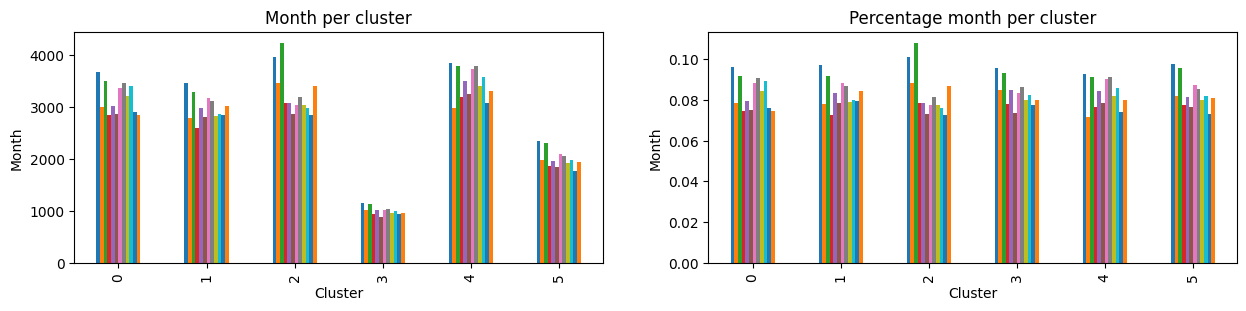

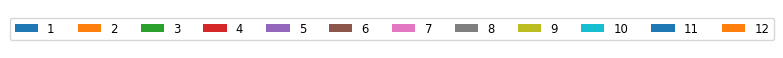

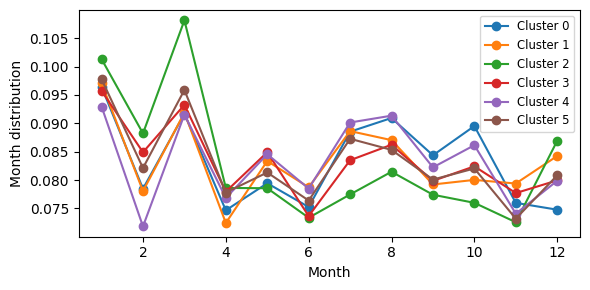

In [152]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [153]:
year_xt_pct = pd.crosstab(best_model.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               7   10755    6584    9429    9383    2037
1              14    6522    7805    9503    9798    2196
2               4    2164    8880   11852   13253    3092
3               2    2026    2666    3137    3479     787
4              10    6194    8327   12140   12322    2522
5               4    4131    5160    6630    6697    1465

In [154]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000183  0.281581  0.172379  0.246865  0.245660  0.053332
1  0.000391  0.181986  0.217786  0.265165  0.273397  0.061276
2  0.000102  0.055141  0.226271  0.302000  0.337699  0.078787
3  0.000165  0.167480  0.220385  0.259320  0.287592  0.065057
4  0.000241  0.149199  0.200578  0.292424  0.296808  0.060749
5  0.000166  0.171503  0.214223  0.275252  0.278034  0.060821

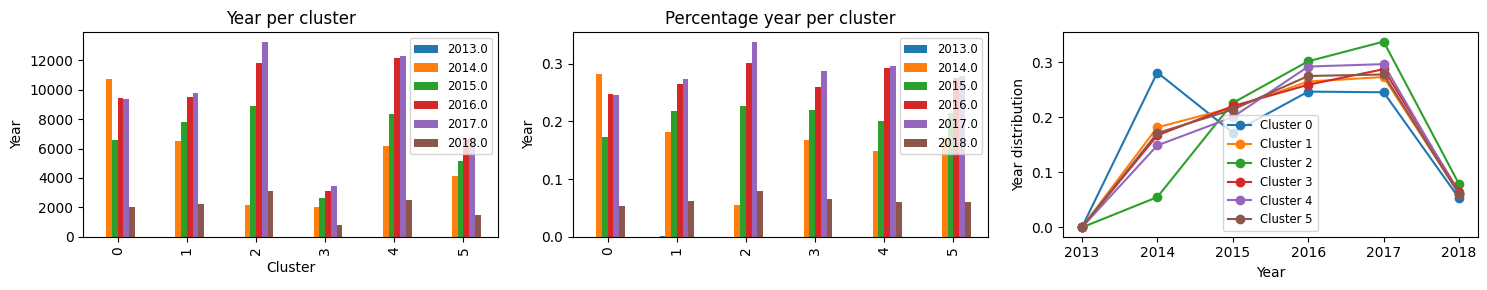

In [155]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [156]:
state_xt_pct = pd.crosstab(best_model.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          669      65      309       468        1929       593          548   
1         1065      21      609       442        2333       557          300   
2          620      24      274       465        2519       688          926   
3          237       3      103       164         592       157          127   
4         1083      24      335       478        1885       477          604   
5          663      20      280       395        1032       393          270   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           294     2215     1687  ...           102       1157   2061   181   
1           171     2236     1449  ...            68       1115   2436   157   
2           302     2531     1121  ...           160       1035   1674   209   
3           126      725      456  ...            28        459    565    57   
4           414     2026     1420  ...            75       1532   1334   128   
5           128     1496     1123  ...            57        850   1460   120   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          100       849         514            262        859       77  
1           39       876         495            189        686       82  
2          134       765         790            418        725      136  
3            9       403         172             47        277       18  
4           35      1373         440            210       1103       64  
5           68       584         412            199        543       74  

[6 rows x 50 columns]

In [157]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.017515  0.001702  0.008090  0.012253    0.050504  0.015526     0.014347   
1  0.029717  0.000586  0.016993  0.012333    0.065098  0.015542     0.008371   
2  0.015798  0.000612  0.006982  0.011849    0.064187  0.017531     0.023595   
3  0.019592  0.000248  0.008515  0.013557    0.048938  0.012978     0.010498   
4  0.026087  0.000578  0.008069  0.011514    0.045405  0.011490     0.014549   
5  0.027525  0.000830  0.011625  0.016399    0.042845  0.016316     0.011209   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.007697  0.057992  0.044168  ...      0.002671   0.030292  0.053960   
1  0.004771  0.062392  0.040432  ...      0.001897   0.031112  0.067973   
2  0.007695  0.064492  0.028564  ...      0.004077   0.026373  0.042655   
3  0.010416  0.059932  0.037695  ...      0.002315   0.037943  0.046706   
4  0.009972  0.048802  0.034205  ...      0.001807   0.036902  0.032133   
5  0.005314  0.062108  0.046623  ...      0.002366   0.035289  0.060614   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004739  0.002618  0.022228    0.013457       0.006860   0.022490   
1  0.004381  0.001088  0.024443    0.013812       0.005274   0.019142   
2  0.005326  0.003414  0.019493    0.020130       0.010651   0.018474   
3  0.004712  0.000744  0.033314    0.014218       0.003885   0.022898   
4  0.003083  0.000843  0.033072    0.010599       0.005058   0.026569   
5  0.004982  0.002823  0.024245    0.017105       0.008262   0.022543   

    WYOMING  
0  0.002016  
1  0.002288  
2  0.003465  
3  0.001488  
4  0.001542  
5  0.003072  

[6 rows x 50 columns]

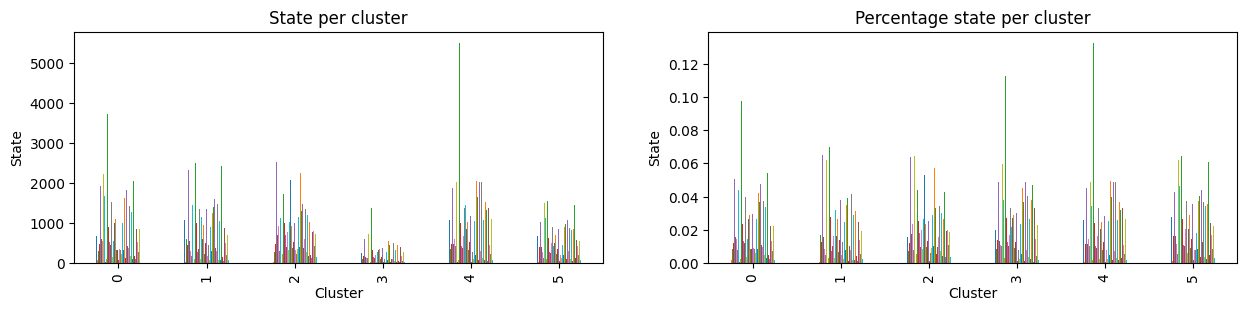

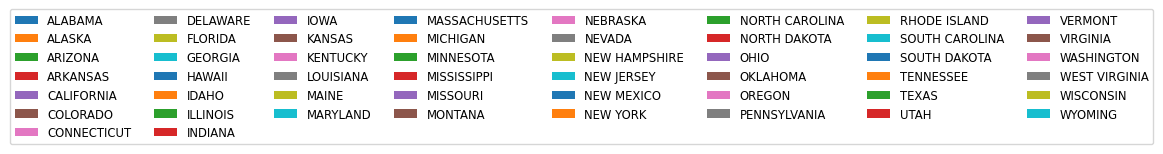

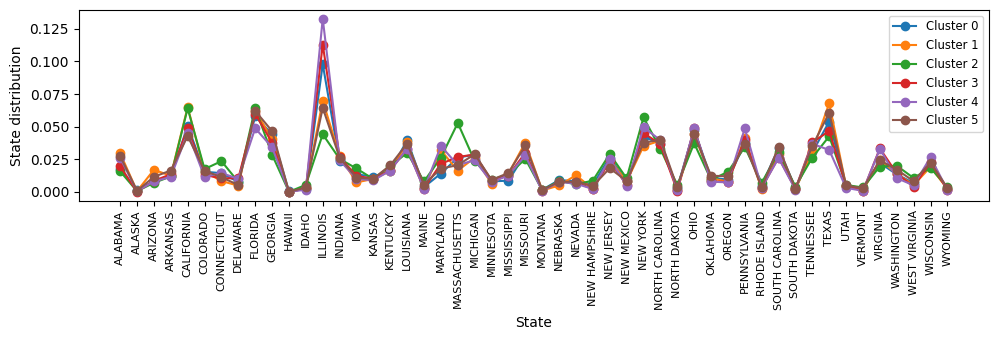

In [158]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [159]:
ic_xt_pct = pd.crosstab(best_model.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   4984                  225   
1                                     79                    9   
2                                     92                   40   
3                                     91                   15   
4                                    121                   13   
5                                    504                   37   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 1                 12   
1                                                 0                  2   
2                                                 2                  2   
3                                                 0                  1   
4                                                 0                  3   
5                                                 1                  1   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  165                            19   
1                                    8                             1   
2                                   17                             2   
3                                    9                             0   
4                                    6                             2   
5                                   53                             4   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     21                 59        25   
1                                      5                  0         3   
2                                      4                  8         8   
3                                      1                  2         4   
4                                      0                  3        12   
5                                      5                120        10   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       573  ...                  64   
1                                        17  ...                  51   
2                                       113  ...                  43   
3                                        16  ...                   8   
4                                        30  ...                  31   
5                                        96  ...                  42   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     2               1         303        1   
1                                     0               0          68       26   
2                                     1               1          95        1   
3                                     0               0          44        1   
4                                     1               0          75        0   
5                                     0               1          75        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       25         421                1   
1                                        5         411                0   
2                                       16         396                4   
3                                        1         124                0   
4                                        8         394  

In [160]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.130488             0.005891                  0.000026   
1       0.002204             0.000251                  0.000000   
2       0.002344             0.001019                  0.000051   
3       0.007523             0.001240                  0.000000   
4       0.002915             0.000313                  0.000000   
5       0.020924             0.001536                  0.000042   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000314     0.004320                      0.000497   
1           0.000056     0.000223                      0.000028   
2           0.000051     0.000433                      0.000051   
3           0.000083     0.000744                      0.000000   
4           0.000072     0.000145                      0.000048   
5           0.000042     0.002200                      0.000166   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000550           0.001545  0.000655          0.015002  ...   
1       0.000140           0.000000  0.000084          0.000474  ...   
2       0.000102           0.000204  0.000204          0.002879  ...   
3       0.000083           0.000165  0.000331          0.001323  ...   
4       0.000000           0.000072  0.000289          0.000723  ...   
5       0.000208           0.004982  0.000415          0.003986  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001676      0.000052        0.000026    0.007933  0.000026   
1            0.001423      0.000000        0.000000    0.001897  0.000725   
2            0.001096      0.000025        0.000025    0.002421  0.000025   
3            0.000661      0.000000        0.000000    0.003637  0.000083   
4            0.000747      0.000024        0.000000    0.001807  0.000000   
5            0.001744      0.000000        0.000042    0.003114  0.000042   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000655    0.011022         0.000026        0.022254   
1         0.000140    0.011468         0.000000        0.000809   
2         0.000408    0.010090         0.000102        0.001707   
3         0.000083    0.010250         0.000000        0.004877   
4         0.000193    0.009491         0.000000        0.000771   
5         0.000664    0.010462         0.000000        0.004069   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000000  
2                0.000025  
3                0.000000  
4                0.000000  
5                0.000000  

[6 rows x 49 columns]

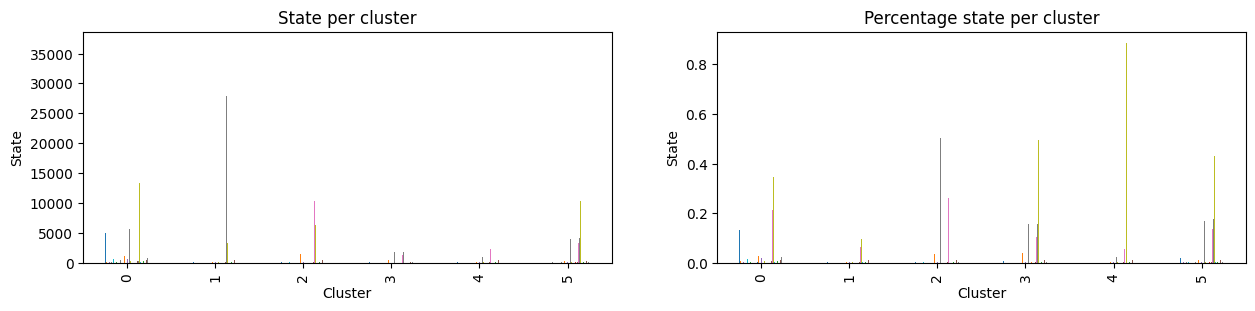

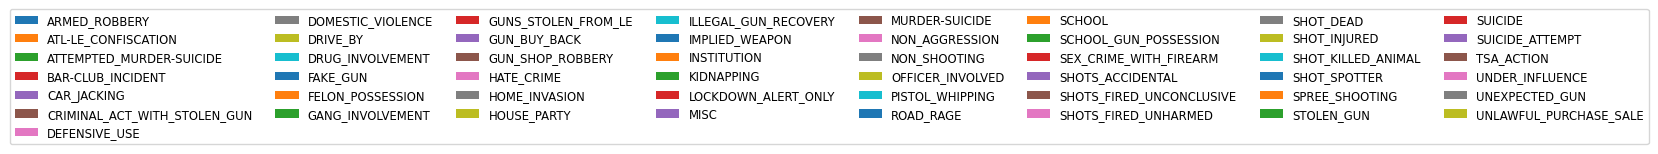

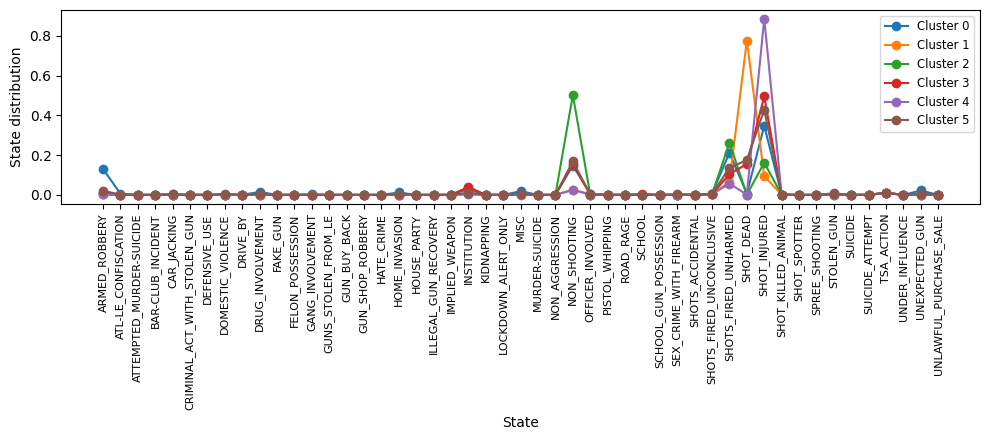

In [161]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Reduced augmented data clustering

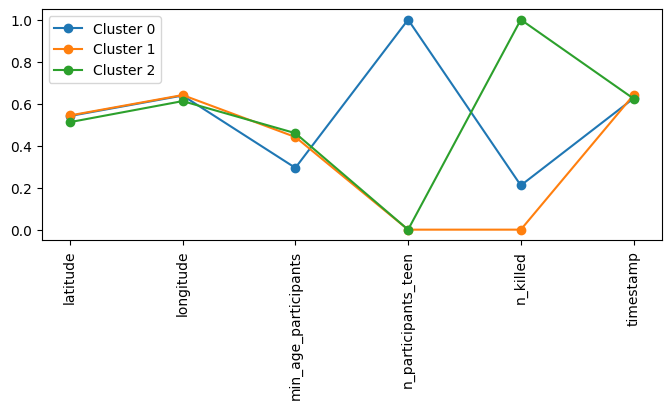

In [162]:
centers = best_model_r.cluster_centers_
cols = reduced.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

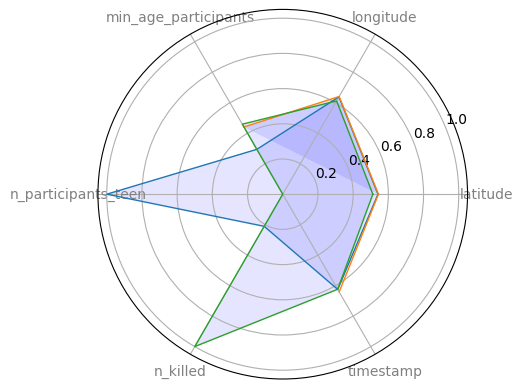

In [163]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [164]:
party_xt_pct = pd.crosstab(best_model_r.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0          7929        5334
1         76489       58831
2         25096       17298

In [165]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.597829    0.402171
1  0.565245    0.434755
2  0.591971    0.408029

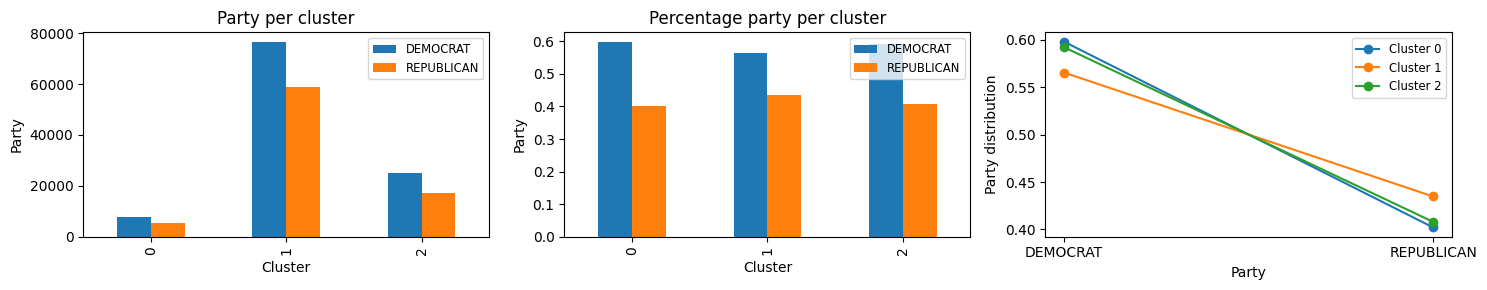

In [166]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [167]:
day_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0          488   425   403   409   457   452   421   428   451   406  ...   
1         4990  4292  4384  4381  4495  4361  4376  4385  4277  4212  ...   
2         1482  1313  1346  1426  1399  1416  1374  1376  1339  1394  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0          398   433   424   434   425   426   434   416   400   239  
1         4354  4346  4264  4633  4493  4514  4474  4227  4097  2699  
2         1329  1457  1368  1408  1435  1447  1415  1300  1309   878  

[3 rows x 31 columns]

In [168]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036794  0.032044  0.030385  0.030838  0.034457  0.034080  0.031742   
1  0.036876  0.031717  0.032397  0.032375  0.033218  0.032227  0.032338   
2  0.034958  0.030971  0.031750  0.033637  0.033000  0.033401  0.032410   

         8         9         10  ...        22        23        24        25  \
0  0.032270  0.034004  0.030611  ...  0.030008  0.032647  0.031969  0.032723   
1  0.032405  0.031607  0.031126  ...  0.032176  0.032116  0.031510  0.034237   
2  0.032457  0.031585  0.032882  ...  0.031349  0.034368  0.032269  0.033212   

         26        27        28        29        30        31  
0  0.032044  0.032119  0.032723  0.031365  0.030159  0.018020  
1  0.033203  0.033358  0.033062  0.031237  0.030276  0.019945  
2  0.033849  0.034132  0.033377  0.030665  0.030877  0.020710  

[3 rows x 31 columns]

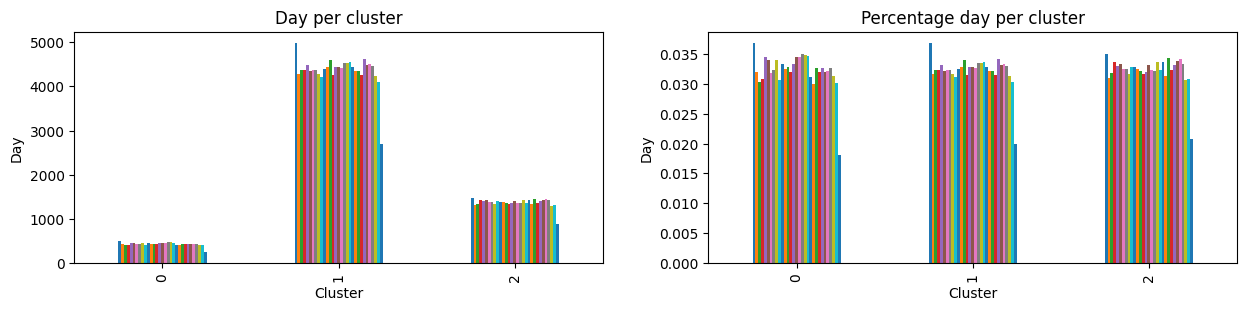

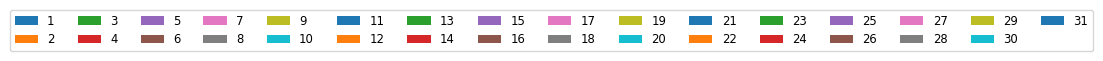

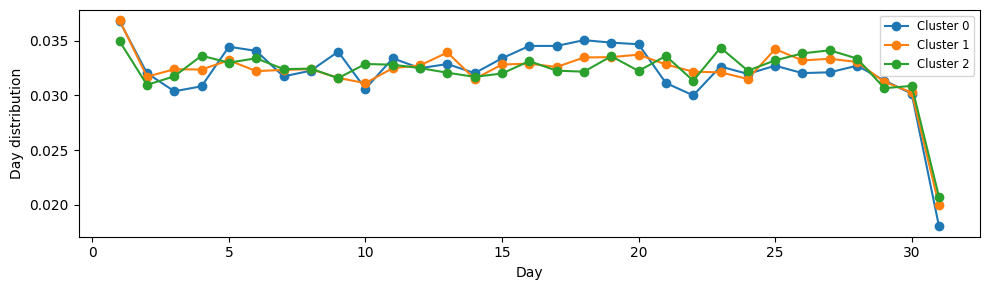

In [169]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [170]:
month_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0            1287   1101   1249   1026   1113   1000   1127   1134   1058   
1           13097  10781  13107  10415  10974  10231  11607  11904  11012   
2            4126   3361   3919   3099   3513   3333   3717   3641   3338   

date_month     10    11     12  
row_0                           
0            1092  1039   1037  
1           11306  9980  10906  
2            3420  3354   3573

In [171]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097037  0.083013  0.094172  0.077358  0.083918  0.075398  0.084973   
1  0.096785  0.079670  0.096859  0.076966  0.081097  0.075606  0.085774   
2  0.097325  0.079280  0.092442  0.073100  0.082865  0.078620  0.087678   

         8         9         10        11        12  
0  0.085501  0.079771  0.082334  0.078338  0.078187  
1  0.087969  0.081377  0.083550  0.073751  0.080594  
2  0.085885  0.078738  0.080672  0.079115  0.084281

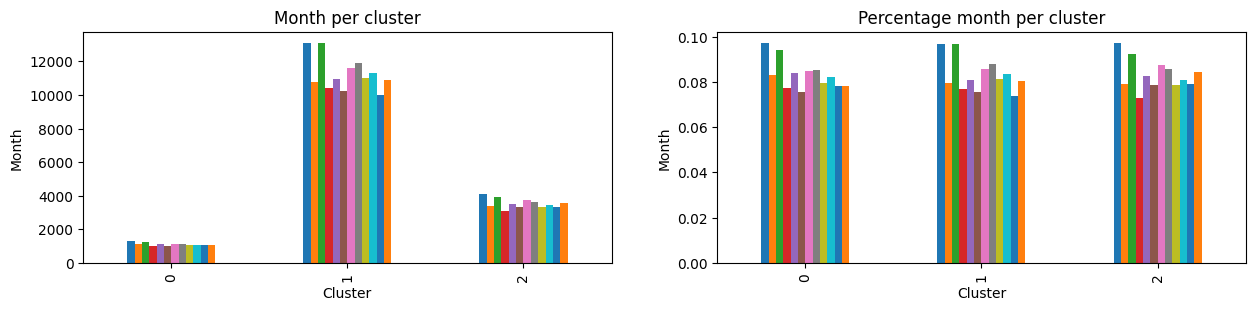

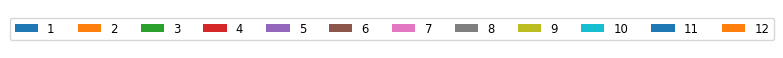

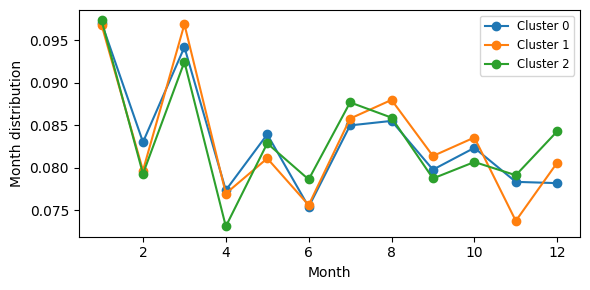

In [172]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [173]:
year_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               2    2450    2869    3408    3697     837
1              23   21525   27366   38030   39705    8671
2              16    7817    9187   11253   11530    2591

In [174]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000151  0.184724  0.216316  0.256955  0.278745  0.063108
1  0.000170  0.159067  0.202232  0.281038  0.293416  0.064078
2  0.000377  0.184389  0.216705  0.265439  0.271972  0.061117

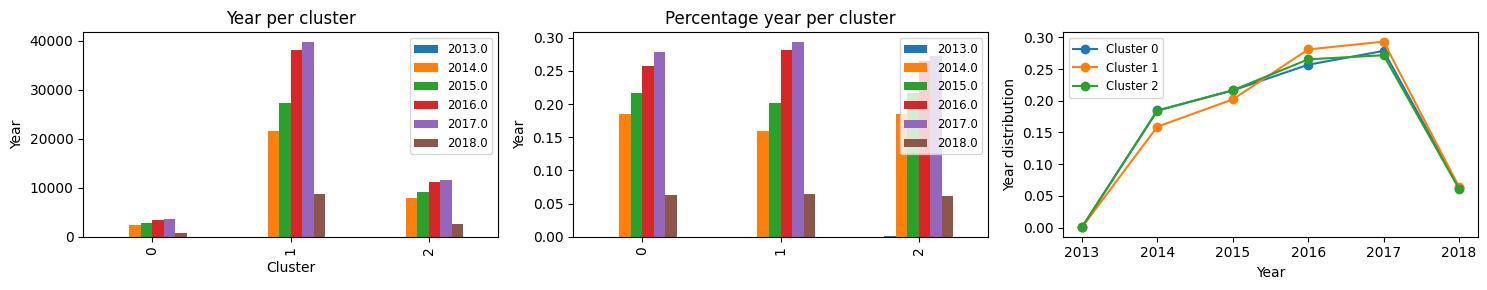

In [175]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [176]:
state_xt_pct = pd.crosstab(best_model_r.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          256       5      114       173         641       173          146   
1         2773     129     1055      1712        6975      2038         2290   
2         1308      23      741       527        2674       654          339   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           133      820      514  ...            33        497    621    63   
1          1114     7761     4970  ...           375       4305   5895   603   
2           188     2648     1772  ...            82       1346   3014   186   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           11       414         194             53        307       20  
1          320      3385        2043           1028       3063      330  
2           54      1051         586            244        823      101  

[3 rows x 50 columns]

In [177]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.019302  0.000377  0.008595  0.013044    0.048330  0.013044     0.011008   
1  0.020492  0.000953  0.007796  0.012651    0.051544  0.015061     0.016923   
2  0.030853  0.000543  0.017479  0.012431    0.063075  0.015427     0.007996   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.010028  0.061826  0.038754  ...      0.002488   0.037473  0.046822   
1  0.008232  0.057353  0.036728  ...      0.002771   0.031813  0.043563   
2  0.004435  0.062462  0.041798  ...      0.001934   0.031750  0.071095   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004750  0.000829  0.031215    0.014627       0.003996   0.023147   
1  0.004456  0.002365  0.025015    0.015098       0.007597   0.022635   
2  0.004387  0.001274  0.024791    0.013823       0.005756   0.019413   

    WYOMING  
0  0.001508  
1  0.002439  
2  0.002382  

[3 rows x 50 columns]

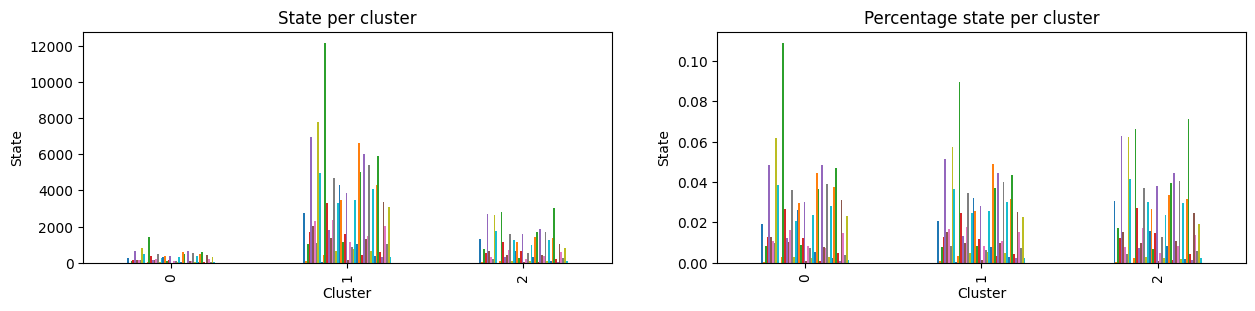

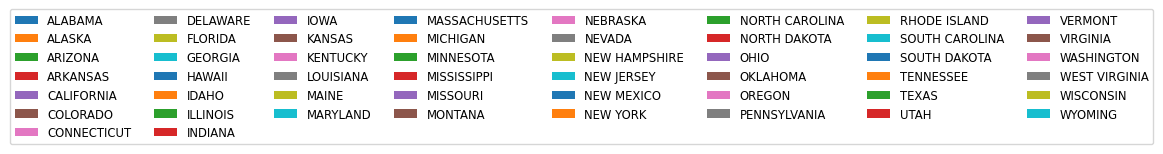

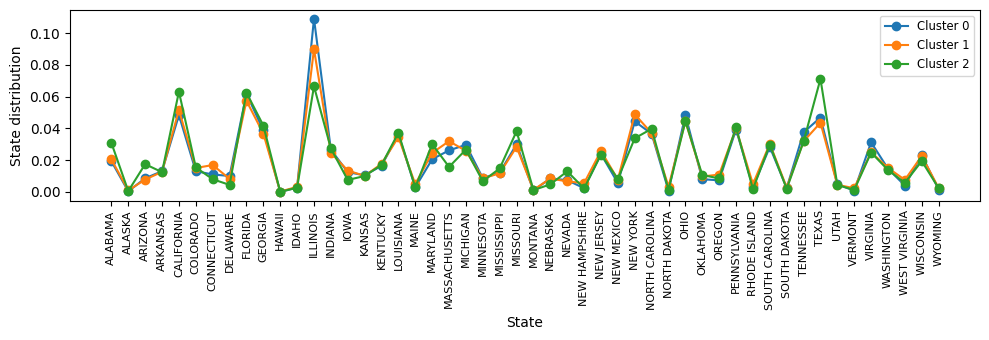

In [178]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [179]:
ic_xt_pct = pd.crosstab(best_model_r.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                    174                   20   
1                                   5605                  307   
2                                     92                   12   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  2   
1                                                 4                 16   
2                                                 0                  3   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   18                             0   
1                                  232                            27   
2                                    8                             1   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      2                  8         5   
1                                     29                181        53   
2                                      5                  3         4   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        25  ...                   9   
1                                       800  ...                 162   
2                                        20  ...                  68   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0          49        1   
1                                     4               3         527        2   
2                                     0               0          84       27   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        3         132                0   
1                                       62        1376                5   
2                                        6         490                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      68                       0  
1                                    1035                       1  
2                                      32                       0  

[3 rows x 49 columns]

In [180]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.013119             0.001508                   0.00000   
1       0.041420             0.002269                   0.00003   
2       0.002170             0.000283                   0.00000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000151     0.001357                      0.000000   
1           0.000118     0.001714                      0.000200   
2           0.000071     0.000189                      0.000024   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000151           0.000603  0.000377          0.001885  ...   
1       0.000214           0.001338  0.000392          0.005912  ...   
2       0.000118           0.000071  0.000094          0.000472  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.000679       0.00000        0.000000    0.003694  0.000075   
1            0.001197       0.00003        0.000022    0.003894  0.000015   
2            0.001604       0.00000        0.000000    0.001981  0.000637   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000226    0.009952         0.000000        0.005127   
1         0.000458    0.010168         0.000037        0.007649   
2         0.000142    0.011558         0.000000        0.000755   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000007  
2                0.000000  

[3 rows x 49 columns]

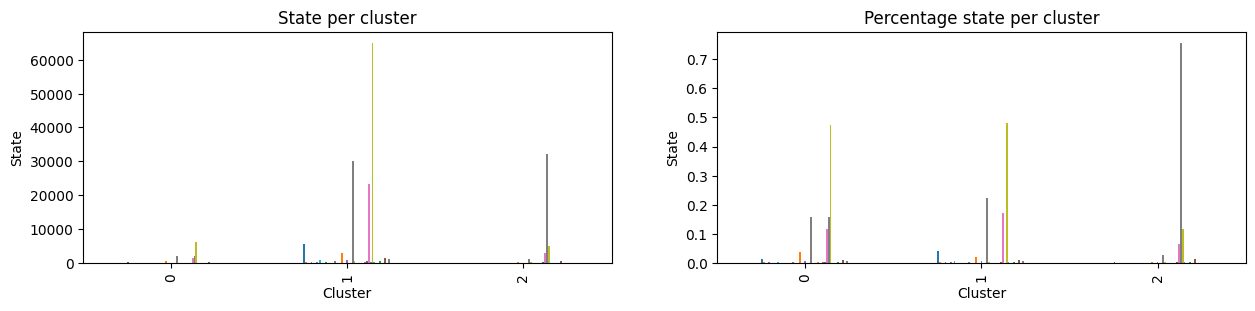

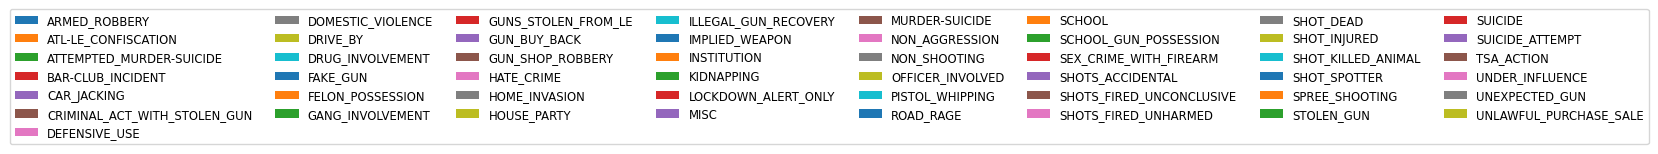

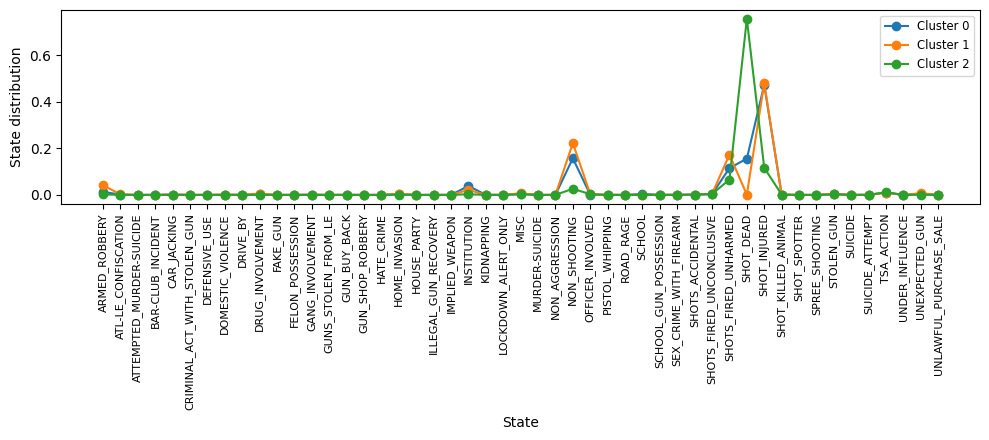

In [181]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Only indicators clustering

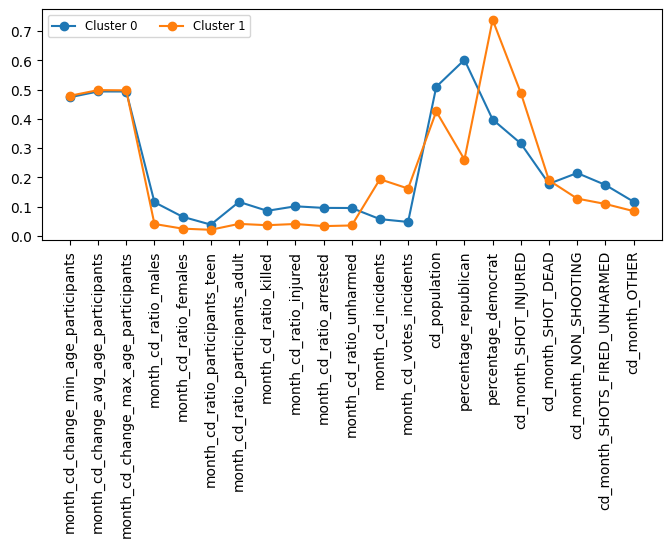

In [182]:
centers = best_model_ind.cluster_centers_
cols = df_ind.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend(fontsize='small', ncol=2)
plt.show()

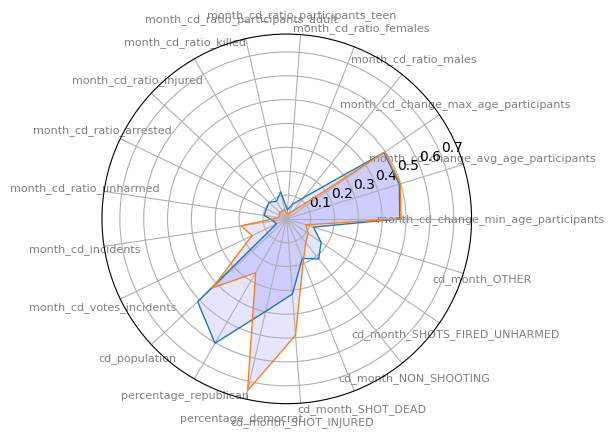

In [183]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [184]:
party_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         21421       79909
1         88093        1554

In [185]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.211398    0.788602
1  0.982665    0.017335

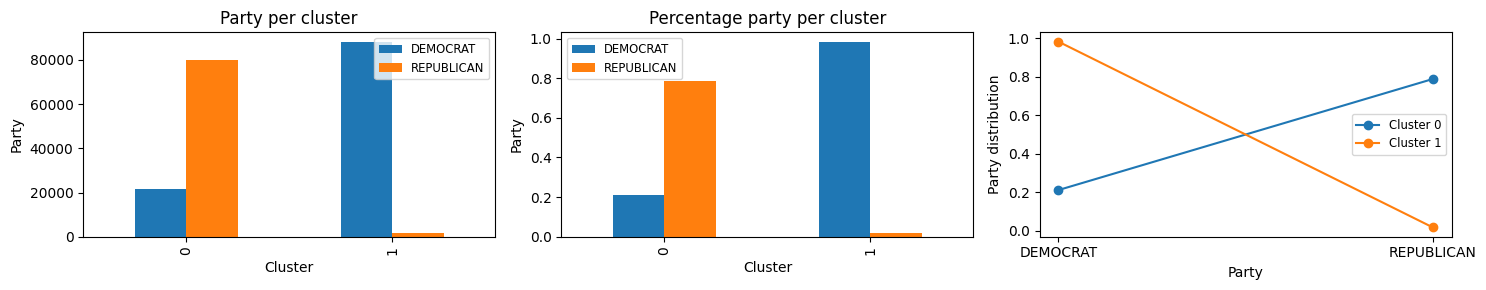

In [186]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [187]:
day_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         3750  3196  3259  3239  3352  3307  3247  3329  3230  3224  ...   
1         3210  2834  2874  2977  2999  2922  2924  2860  2837  2788  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         3236  3293  3133  3412  3433  3430  3360  3099  3050  1983  
1         2845  2943  2923  3063  2920  2957  2963  2844  2756  1833  

[2 rows x 31 columns]

In [188]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.037008  0.031541  0.032162  0.031965  0.033080  0.032636  0.032044   
1  0.035807  0.031613  0.032059  0.033208  0.033453  0.032595  0.032617   

         8         9         10  ...        22        23        24        25  \
0  0.032853  0.031876  0.031817  ...  0.031935  0.032498  0.030919  0.033672   
1  0.031903  0.031646  0.031100  ...  0.031736  0.032829  0.032606  0.034167   

         26        27        28        29        30        31  
0  0.033879  0.033850  0.033159  0.030583  0.030100  0.019570  
1  0.032572  0.032985  0.033052  0.031724  0.030743  0.020447  

[2 rows x 31 columns]

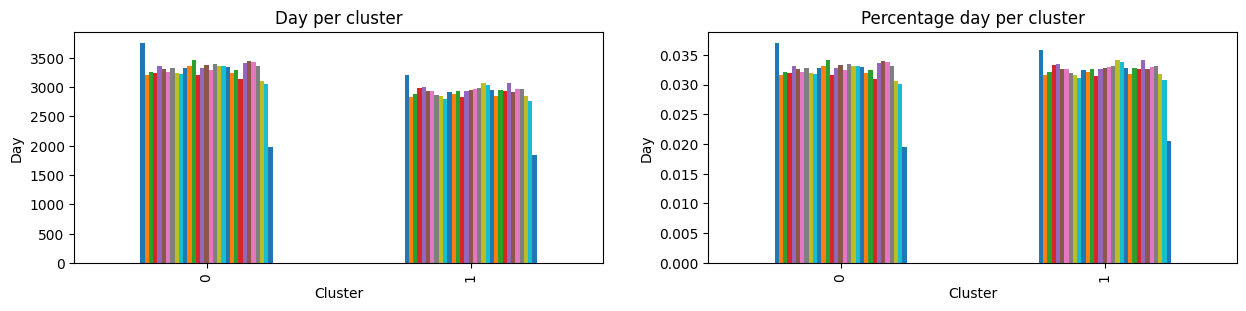

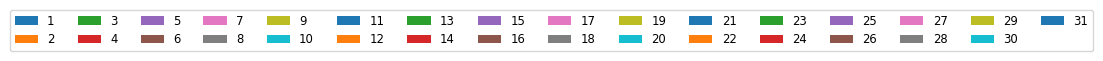

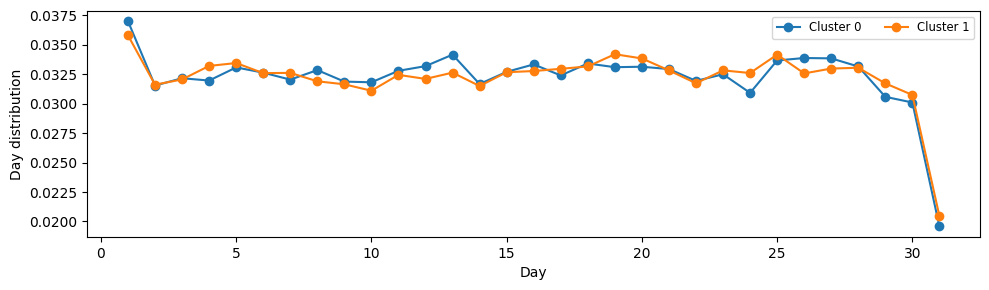

In [189]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=5)
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [190]:
month_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_month'])
month_xt_pct

date_month     1     2      3     4     5     6     7     8     9     10  \
row_0                                                                      
0           10366  8790  10039  7662  7778  7655  8304  8351  7917  8369   
1            8144  6453   8236  6878  7822  6909  8147  8328  7491  7449   

date_month    11    12  
row_0                   
0           7741  8358  
1           6632  7158

In [191]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.102299  0.086746  0.099072  0.075614  0.076759  0.075545  0.081950   
1  0.090845  0.071982  0.091871  0.076723  0.087253  0.077069  0.090879   

         8         9         10        11        12  
0  0.082414  0.078131  0.082592  0.076394  0.082483  
1  0.092898  0.083561  0.083093  0.073979  0.079847

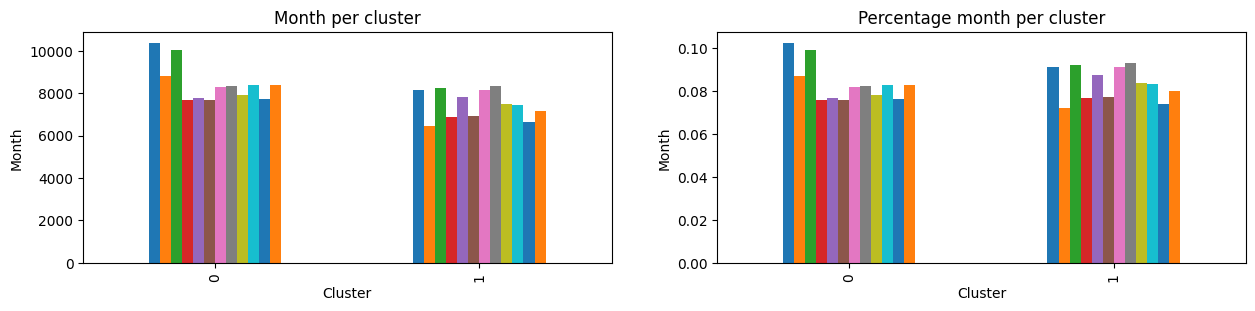

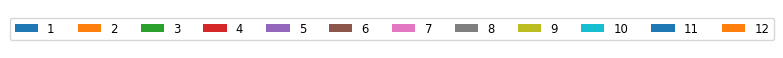

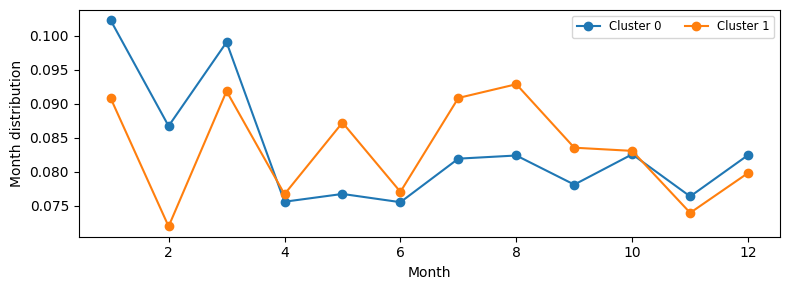

In [192]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(8, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=5)
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [193]:
year_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              23   17446   22351   26691   28333    6486
1              18   14346   17071   26000   26599    5613

In [194]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000227  0.172170  0.220576  0.263407  0.279611  0.064009
1  0.000201  0.160028  0.190425  0.290026  0.296708  0.062612

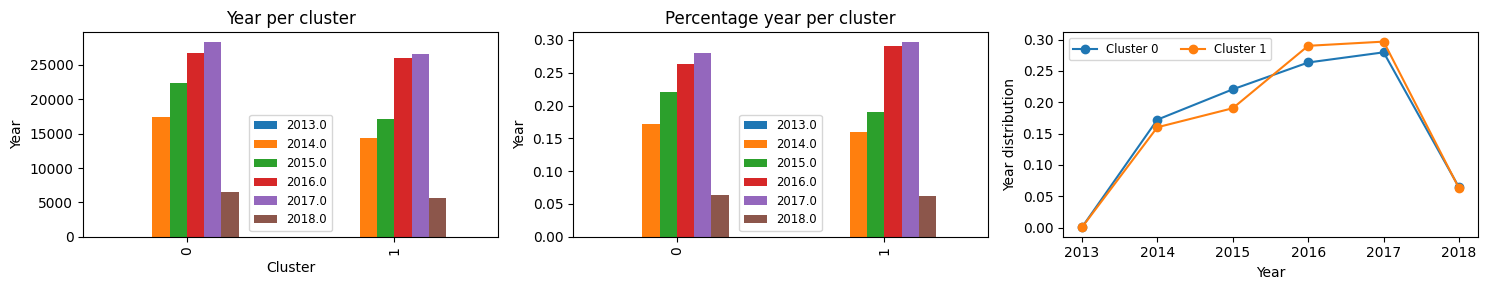

In [195]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small', ncols=2)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [196]:
state_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         2651     157      929      2406        4915      2338         1586   
1         1686       0      981         6        5375       527         1189   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           451     7808     4077  ...           490       3018   6049   852   
1           984     3421     3179  ...             0       3130   3481     0   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          163      2382        1992           1291       1328      451  
1          222      2468         831             34       2865        0  

[2 rows x 50 columns]

In [197]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.026162  0.001549  0.009168  0.023744    0.048505  0.023073     0.015652   
1  0.018807  0.000000  0.010943  0.000067    0.059957  0.005879     0.013263   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.004451  0.077055  0.040235  ...      0.004836   0.029784  0.059696   
1  0.010976  0.038161  0.035461  ...      0.000000   0.034915  0.038830   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.008408  0.001609  0.023507    0.019659       0.012741   0.013106   
1  0.000000  0.002476  0.027530    0.009270       0.000379   0.031959   

    WYOMING  
0  0.004451  
1  0.000000  

[2 rows x 50 columns]

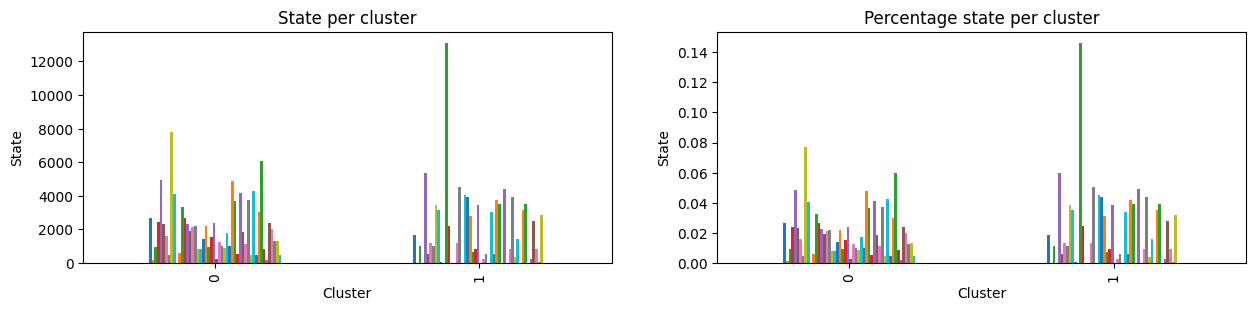

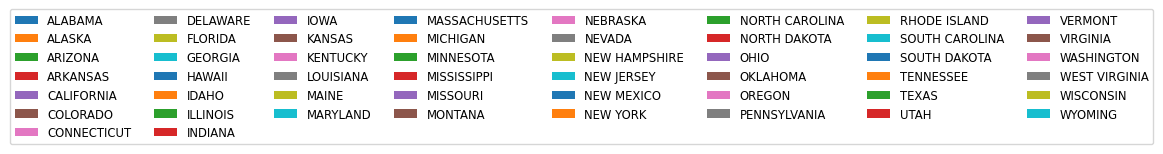

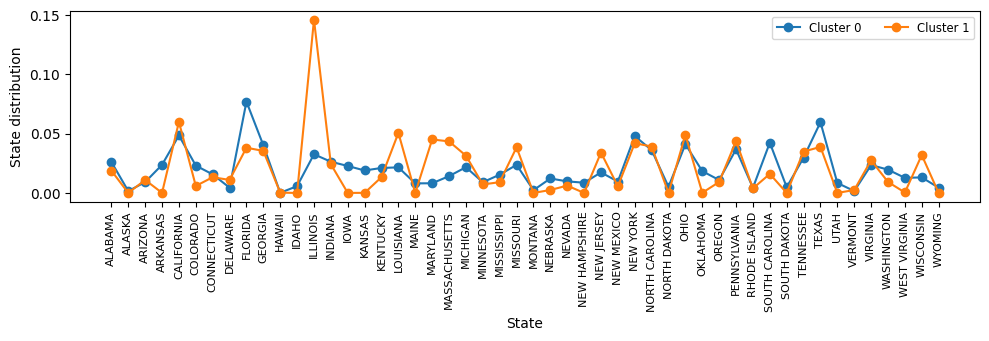

In [198]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=2)
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [199]:
ic_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   3528                  217   
1                                   2343                  122   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 1                 14   
1                                                 3                  7   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  106                            22   
1                                  152                             6   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     22                133        37   
1                                     14                 59        25   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       573  ...                 184   
1                                       272  ...                  55   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               2         531       22   
1                                     4               1         129        8   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       53        1019                3   
1                                       18         979                2   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                     626                       0  
1                                     509                       1  

[2 rows x 49 columns]

In [201]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.034817             0.002142                  0.000010   
1       0.026136             0.001361                  0.000033   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000138     0.001046                      0.000217   
1           0.000078     0.001696                      0.000067   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000217           0.001313  0.000365          0.005655  ...   
1       0.000156           0.000658  0.000279          0.003034  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001816      0.000000        0.000020    0.005240  0.000217   
1            0.000614      0.000045        0.000011    0.001439  0.000089   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000523    0.010056         0.000030        0.006178   
1         0.000201    0.010921         0.000022        0.005678   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000011  

[2 rows x 49 columns]

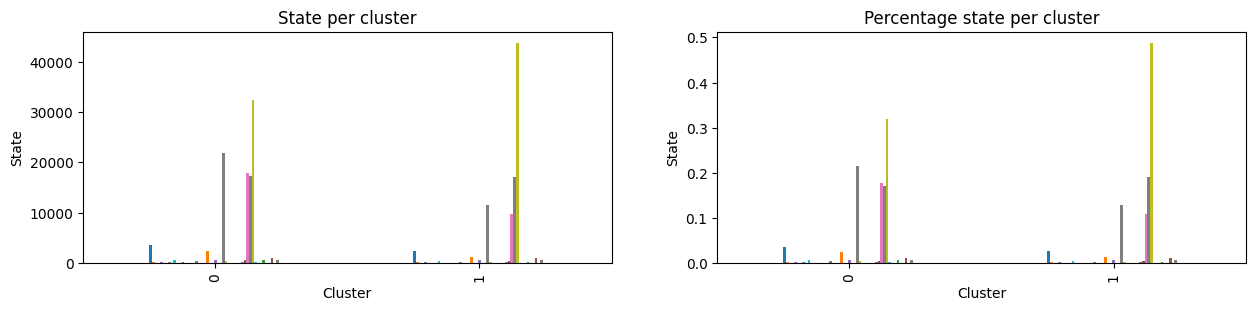

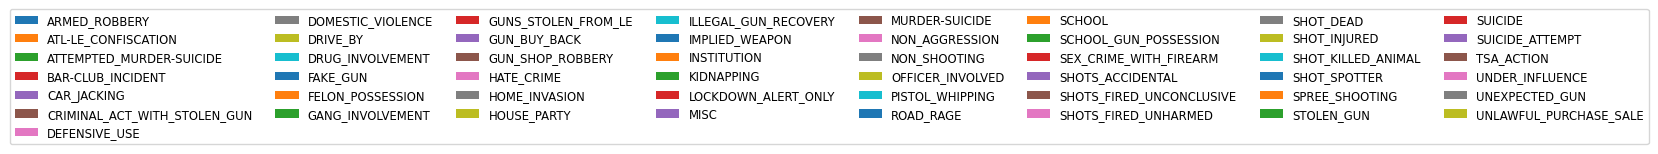

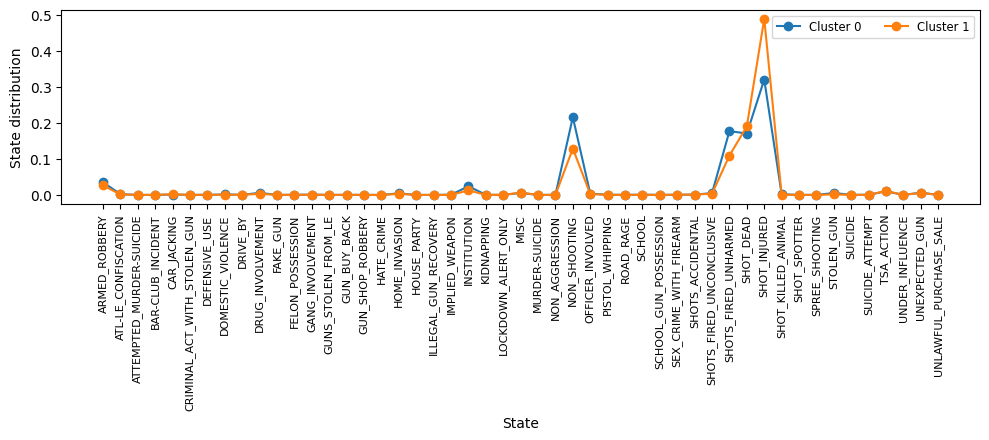

In [202]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=2)
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Only indicators reduced clustering

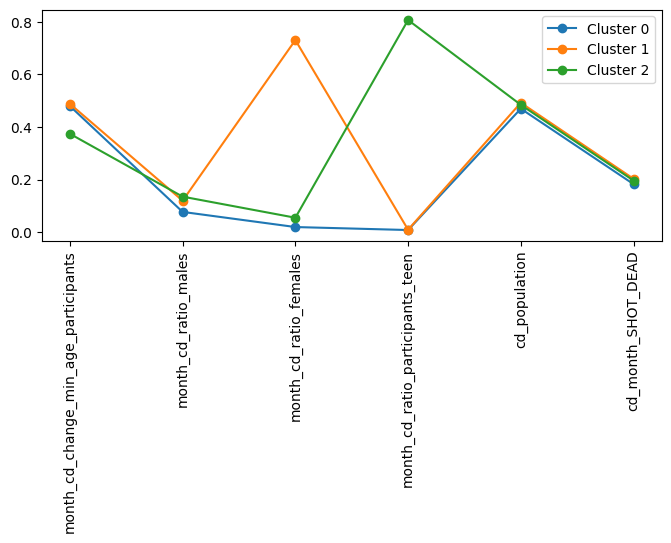

In [204]:
centers = best_model_r_ind.cluster_centers_
cols = reduced_ind.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

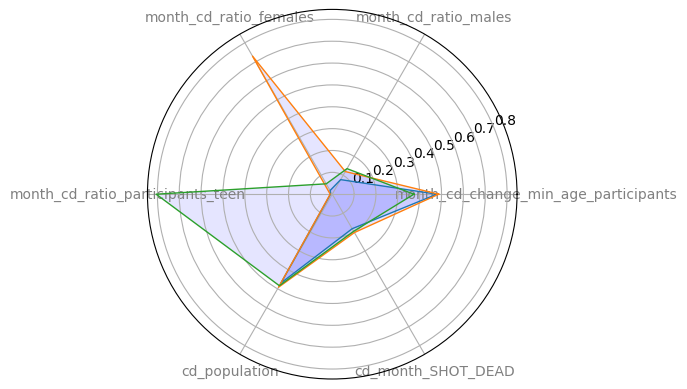

In [205]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [207]:
party_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0        104598       74244
1          2677        4225
2          2239        2994

In [208]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.584863    0.415137
1  0.387859    0.612141
2  0.427862    0.572138

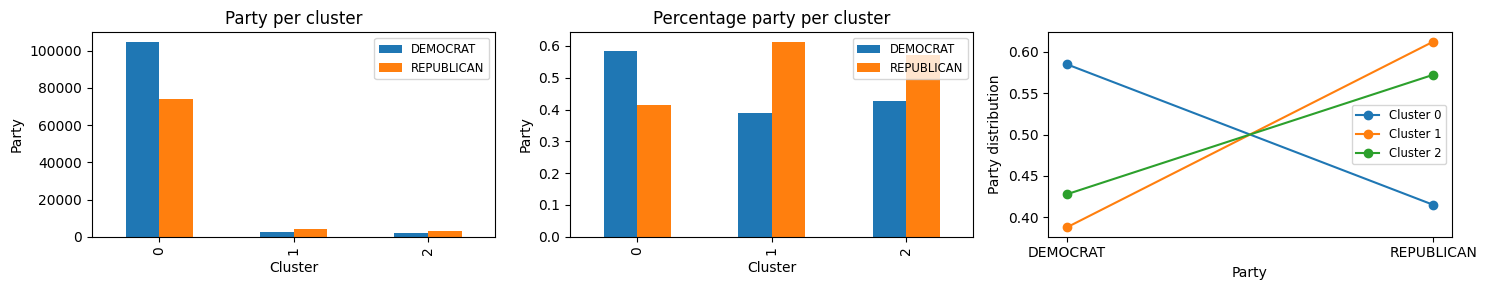

In [209]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [211]:
day_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         6509  5616  5758  5832  5948  5817  5786  5818  5675  5675  ...   
1          272   220   212   231   220   232   229   194   218   190  ...   
2          179   194   163   153   183   180   156   177   174   147  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         5689  5814  5708  6039  5932  5989  5897  5577  5430  3589  
1          224   256   201   256   236   222   233   213   242   141  
2          168   166   147   180   185   176   193   153   134    86  

[3 rows x 31 columns]

In [212]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036395  0.031402  0.032196  0.032610  0.033258  0.032526  0.032353   
1  0.039409  0.031875  0.030716  0.033469  0.031875  0.033613  0.033179   
2  0.034206  0.037072  0.031148  0.029238  0.034970  0.034397  0.029811   

         8         9         10  ...        22        23        24        25  \
0  0.032532  0.031732  0.031732  ...  0.031810  0.032509  0.031916  0.033767   
1  0.028108  0.031585  0.027528  ...  0.032454  0.037091  0.029122  0.037091   
2  0.033824  0.033251  0.028091  ...  0.032104  0.031722  0.028091  0.034397   

         26        27        28        29        30        31  
0  0.033169  0.033488  0.032973  0.031184  0.030362  0.020068  
1  0.034193  0.032165  0.033758  0.030861  0.035062  0.020429  
2  0.035353  0.033633  0.036881  0.029238  0.025607  0.016434  

[3 rows x 31 columns]

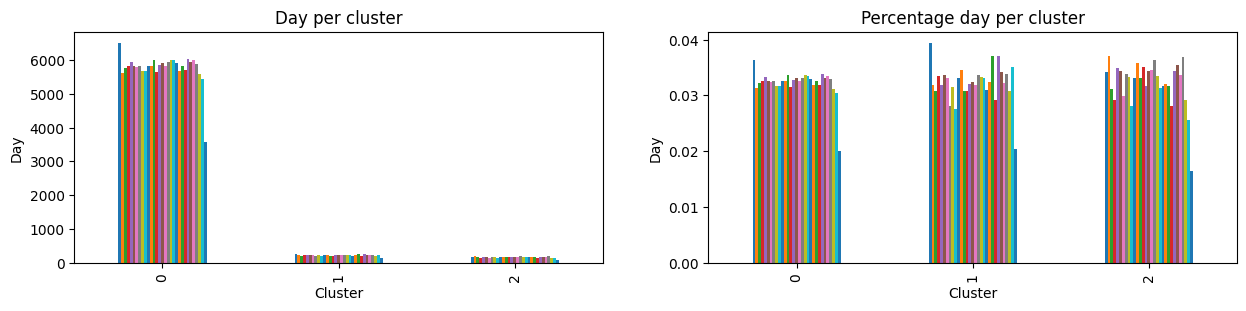

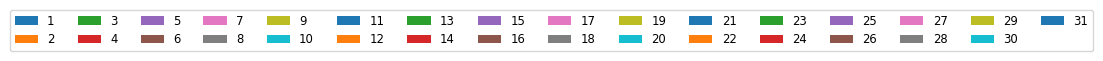

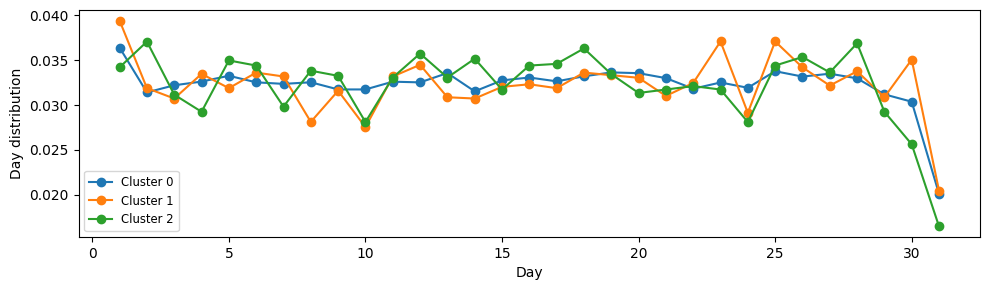

In [213]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [214]:
month_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0           17278  14031  17076  13608  14650  13685  15534  15717  14466   
1             710    698    708    519    511    518    522    559    525   
2             522    514    491    413    439    361    395    403    417   

date_month     10     11     12  
row_0                            
0           14832  13387  14578  
1             561    542    529  
2             425    444    409

In [215]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096610  0.078455  0.095481  0.076090  0.081916  0.076520  0.086859   
1  0.102869  0.101130  0.102579  0.075196  0.074037  0.075051  0.075630   
2  0.099752  0.098223  0.093828  0.078922  0.083891  0.068985  0.075483   

         8         9         10        11        12  
0  0.087882  0.080887  0.082934  0.074854  0.081513  
1  0.080991  0.076065  0.081281  0.078528  0.076644  
2  0.077011  0.079687  0.081215  0.084846  0.078158

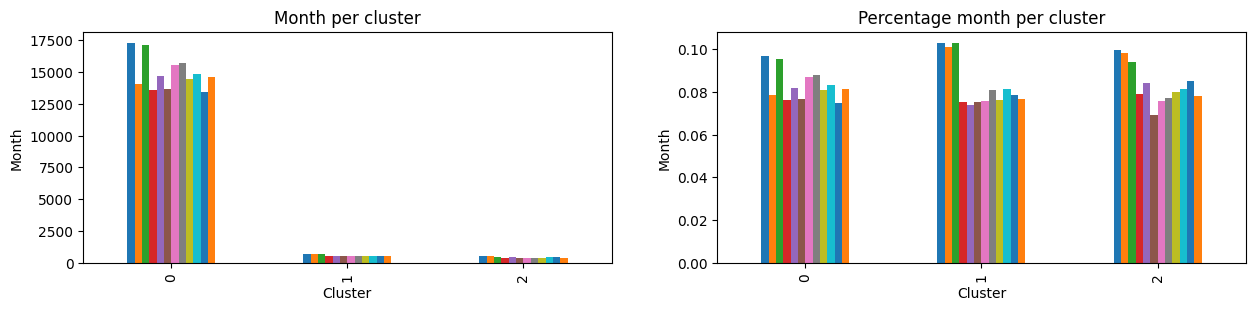

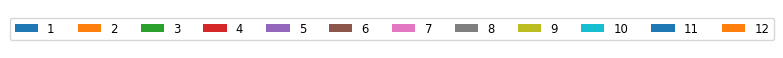

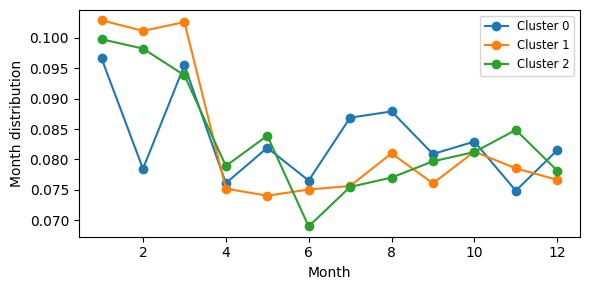

In [216]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [218]:
year_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              35   29283   36608   49723   51827   11366
1               4    1447    1641    1676    1716     418
2               2    1062    1173    1292    1389     315

In [219]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000196  0.163737  0.204695  0.278028  0.289792  0.063553
1  0.000580  0.209649  0.237757  0.242828  0.248624  0.060562
2  0.000382  0.202943  0.224154  0.246895  0.265431  0.060195

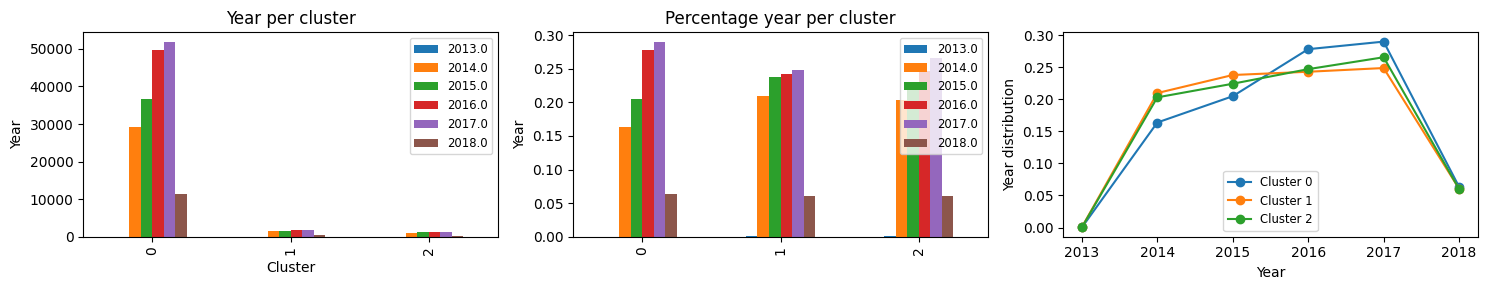

In [220]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [222]:
state_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         4105     157     1678      2263        9360      2631         2618   
1          107       0      148        79         543       142           93   
2          125       0       84        70         387        92           64   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1407    10482     6847  ...           450       5859   8595   751   
1            10      416      213  ...            22        151    558    64   
2            18      331      196  ...            18        138    377    37   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          347      4533        2513           1195       3979      413  
1           28       187         197             78        125       25  
2           10       130         113             52         89       13  

[3 rows x 50 columns]

In [223]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.022953  0.000878  0.009383  0.012654    0.052337  0.014711     0.014639   
1  0.015503  0.000000  0.021443  0.011446    0.078673  0.020574     0.013474   
2  0.023887  0.000000  0.016052  0.013377    0.073954  0.017581     0.012230   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.007867  0.058610  0.038285  ...      0.002516   0.032761  0.048059   
1  0.001449  0.060272  0.030861  ...      0.003187   0.021878  0.080846   
2  0.003440  0.063252  0.037455  ...      0.003440   0.026371  0.072043   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004199  0.001940  0.025346    0.014052       0.006682   0.022249   
1  0.009273  0.004057  0.027094    0.028542       0.011301   0.018111   
2  0.007071  0.001911  0.024842    0.021594       0.009937   0.017007   

    WYOMING  
0  0.002309  
1  0.003622  
2  0.002484  

[3 rows x 50 columns]

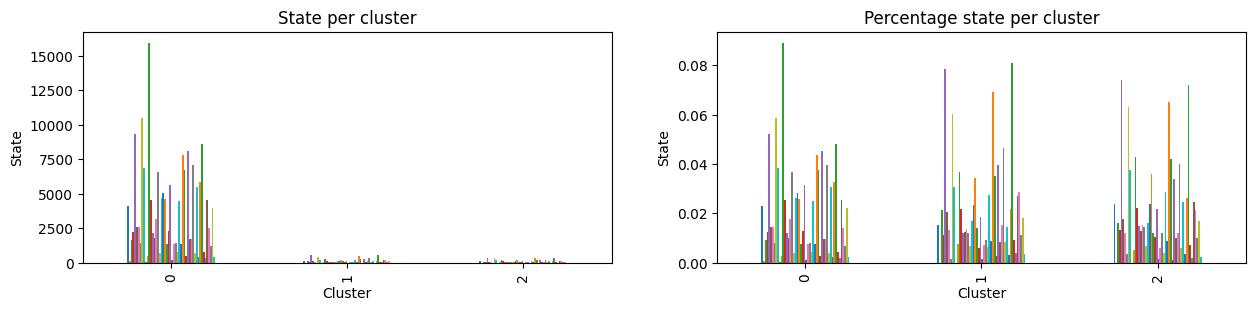

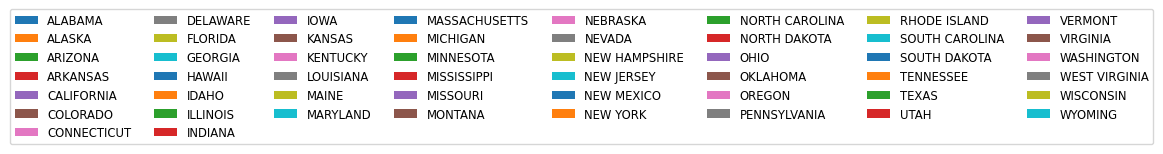

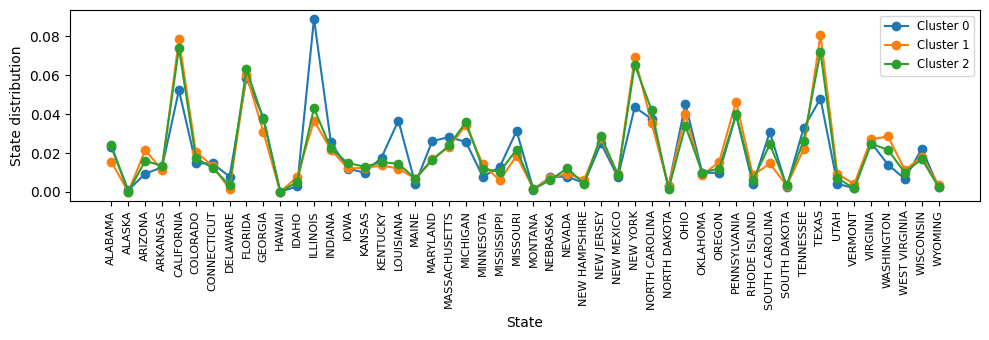

In [224]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [226]:
ic_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   5625                  318   
1                                    158                   12   
2                                     88                    9   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 4                 20   
1                                                 0                  0   
2                                                 0                  1   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  228                            27   
1                                   21                             1   
2                                    9                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     34                146        57   
1                                      1                 41         3   
2                                      1                  5         2   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       793  ...                 211   
1                                        38  ...                  23   
2                                        14  ...                   5   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     4               2         610       30   
1                                     0               1          26        0   
2                                     0               0          24        0   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       61        1857                4   
1                                        7          79                1   
2                                        3          62                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                    1073                       1  
1                                      39                       0  
2                                      23                       0  

[3 rows x 49 columns]

In [227]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.031452             0.001778                  0.000022   
1       0.022892             0.001739                  0.000000   
2       0.016816             0.001720                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000112     0.001275                      0.000151   
1           0.000000     0.003043                      0.000145   
2           0.000191     0.001720                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000190           0.000816  0.000319          0.004434  ...   
1       0.000145           0.005940  0.000435          0.005506  ...   
2       0.000191           0.000955  0.000382          0.002675  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001180      0.000022        0.000011    0.003411  0.000168   
1            0.003332      0.000000        0.000145    0.003767  0.000000   
2            0.000955      0.000000        0.000000    0.004586  0.000000   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000341    0.010383         0.000022        0.006000   
1         0.001014    0.011446         0.000145        0.005651   
2         0.000573    0.011848         0.000000        0.004395   

   UNLAWFUL_PURCHASE_SALE  
0                0.000006  
1                0.000000  
2                0.000000  

[3 rows x 49 columns]

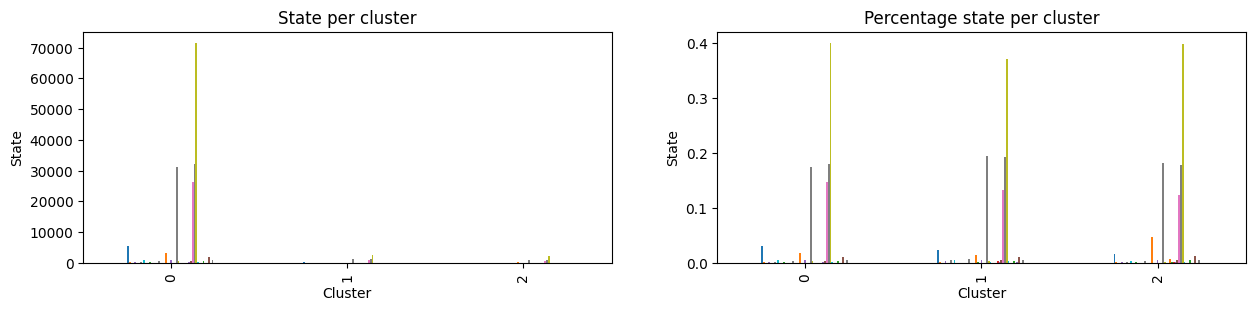

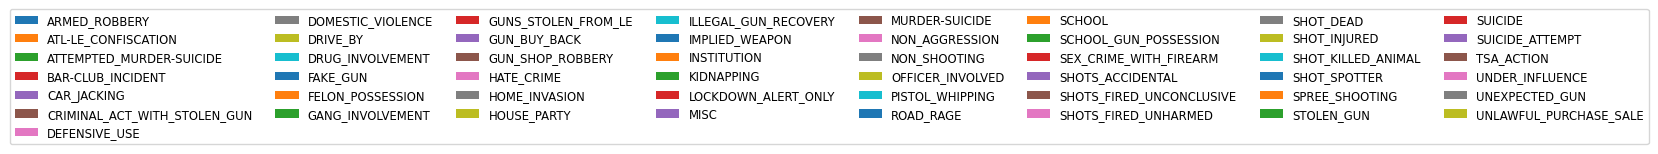

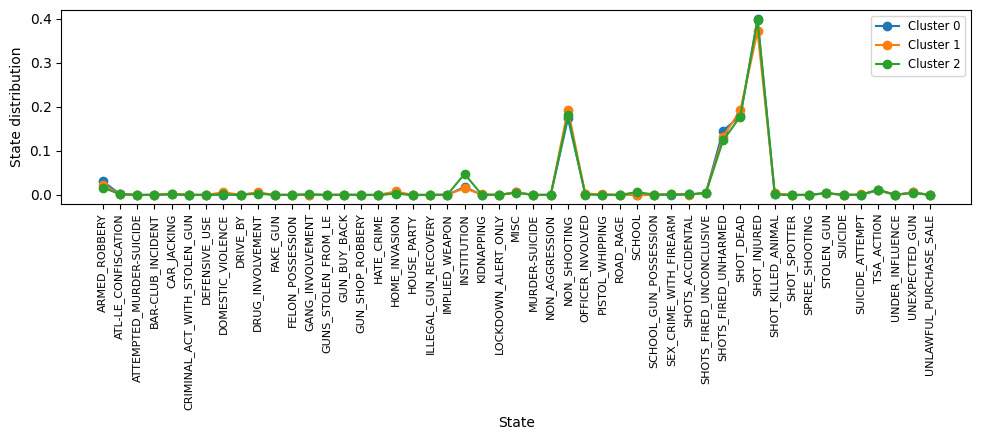

In [228]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()